# Setup

In [1]:
import networkx as nx
import csv
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import io
import numpy as np
import json
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
import random 
import warnings
from math import floor
import sys
import statistics
from collections import Counter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.5f}".format

drive.mount('/content/drive')

Mounted at /content/drive


## Auxiliary Functions and Classes

### Games Class

In [2]:
class Games:
  def __init__(self, player, ratings, opp_ratings, results, sides, openings):
    self._player = player
    self._ratings = ratings
    self._opp_ratings = opp_ratings
    self._results = results
    self._gamecount = len(ratings)
    self._sides = sides 
    self._openings = openings

  def rating(self, index):
    return self._ratings[index]

  def opp_rating(self, index):
    return self._opp_ratings[index]

  def result(self, index):
    return self._results[index]

  def rating_diff(self, index):
    return (self._opp_ratings[index] - self._ratings[index])

  def avg_player_rating(self):
    return sum(self._ratings)/self._gamecount

  def avg_opp_rating(self):
    return sum(self._opp_ratings)/self._gamecount

  def median_rating(self):
    return statMedian(self._ratings)
  
  def percentiles(self):
    q75, q25 = np.percentile(self._ratings, [75 ,25])
    return q75, q25

  def max_rating(self):
    return max(self._ratings)

  def min_rating(self):
    return min(self._ratings)
  
  def player_rating_SD(self):
    return (np.var(self._ratings)**0.5)

  def gamecount(self):
    return self._gamecount

  def side(self, index):
    return self._sides[index]

  def opening(self, index):
    return self._openings[index]

  def preferred_openings(self):
    # Get proportion of preferred openings

    mode = [[x, self._openings.count(x)] for x in set(self._openings)]
    mode = sorted(mode, reverse=True, key = lambda x: x[1])

    try:
      op1 = mode[0][1]
      op1 = op1/len(self._openings)
    except:
      op1 = 0.0

    try:
      op2 = mode[1][1]
      op2 = op2/len(self._openings)

    except:
      op2 = 0.0
    
    try:
      op3 = mode[2][1]
      op3 = op3/len(self._openings)

    except:
      op3 = 0.0
    return op1, op2, op3
  
  
  # def preferred_openings_white(self):
  #   # Get proportion of preferred openings when played as white

  #   white_openings = sorted([self._openings[i] for i in range(len(self._openings)) if (self._sides[i] == 'w')])
  #   mode = [[x, white_openings.count(x)] for x in set(white_openings)]
  #   mode = sorted(mode, reverse=True, key = lambda x: x[1])

    
  #   try:
  #     op1 = mode[0][1]
  #     op1 = op1/len(white_openings)
  #   except:
  #     op1 = 'N/A'

  #   try:
  #     op2 = mode[1][1]
  #     op2 = op2/len(white_openings)

  #   except:
  #     op2 = 'N/A'
    
  #   try:
  #     op3 = mode[2][1]
  #     op3 = op3/len(white_openings)

  #   except:
  #     op3 = 'N/A'
  #   return op1, op2, op3

# games = Games(11406, [1800, 2000, 1900, 1800], [1500, 1400, 1900, 2000], [1, -1, 0, 1])


### Auxiliary Functions

In [3]:
'''
Used to process ratings, opp_ratings, opp_rating_diff and results

Input:  space delimited string
Output: list of elements in the space delimited string
'''
def getList(ls):
  # Return a list of elements in a space delimited string
  return [int(i) for i in ls.split(' ')]

def getListStr(ls):
  # Return a list of elements in a space delimited string
  return [i for i in ls.split(' ')]

def getFullDayCount(df, player):
  full_day_count = []

  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  full_day_count += getList(temp_df['full_day_count'])

  return full_day_count

''' 
Used to process full_day_count

Input:  game_ls             - list of numbers indicating number of games played in each day of a given month (full_day_count)
Output: active_days         - number of days on which the player played at least one game
        inactive_days       - number of days on which the player played no games
        active_periods      - number of consecutive periods of active days
        inactive_periods    - number of consecutive periods of inactive days
'''

def ActiveInactiveDaysAndPeriods(game_ls):
    # Find total number of zeros in the list (days on which player played no games: days of inactivity) and divide by number of periods of inactivity (consecutive days of inactivity)
    # i.e. [0, 1, 1, 0, 0, 1, 1, 0] --> 4 days of inactivity, 3 periods of activity
    # return 4/3 = 1.34 days between sessions on average

    # TODO: Ignore leading and trailing zeros
    # i.e. [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0] gives average 0 days between sessions instead of 4 (8 inactive days/2 inactive periods)
    # game_ls = [int(i) for i in game_ls.split(' ')]

    max_inactive_days = 0
    inactive_days = 0
    active_days = 0
    active_periods = 0
    total_days = len(game_ls)
    for d in range(0, len(game_ls)):
        if(d == len(game_ls) - 1):
            if(game_ls[d] == 0):
                inactive_days += 1
                if(inactive_days > max_inactive_days):
                  max_inactive_days = inactive_days
                inactive_days = 0
            else:
                active_days += 1
                active_periods += 1
        else:
            if(game_ls[d] == 0):
              inactive_days += 1
              if(game_ls[d+1] != 0):
                if(inactive_days > max_inactive_days):
                  max_inactive_days = inactive_days
                inactive_days = 0
            else:
                active_days += 1
                if(game_ls[d+1] == 0):
                    active_periods += 1

    # return active_days, active_periods, max_inactive_days, total_days
    return active_days, total_days

'''
Returns an activity measure based on the number of active and inactive days and periods
Input:  game_ls                 - list of numbers indicating number of games played in each day of a given month (full_day_count)
Output: active_days_proportion  - proportion of active days in a month (e.g. 10 active days in January --> 10/31 == 0.323) max == 1
        avg_daily               - average number of daily games
        avg_active              - average number of games per active day
        avg_rest                - average number of consecutive rest days
        total_games             - total number of games played

New output:
  active_days
  avg_active
  total_games
'''

def getPlayerActivity(game_ls):
  active_days, total_days = ActiveInactiveDaysAndPeriods(game_ls)

  # active_days_proportion = active_days/total_days

  total_games = sum(game_ls)
  # avg_daily = total_games/total_days
  avg_active = total_games/active_days

  return active_days, avg_active, total_games

''' 
Returns a list of all ratings of all players in a given month to be used for variance calculation
Input:  df          - full dataframe
Output: rating_list - full list of all ratings (for all players) for the month

'''

def getAllRatings(df):
  rating_list = []
  
  for player in nodes_dict:
    try:
      temp_df = df.loc[df['player'] == int(player)]
      temp_df = temp_df.iloc[0]
      rating_list += getList(temp_df['ratings'])
    except:
      continue

  return rating_list

''' 
Returns a list of all openings of all players in a given month
Input:  df            - full dataframe
Output: openings_list - full list of all openings (for all players) for the month

'''

def getAllOpenings(df):
  openings_list = []
  
  for player in nodes_dict:
    try:
      temp_df = df.loc[df['player'] == int(player)]
      temp_df = temp_df.iloc[0]
      openings_list += getListStr(temp_df['openings'])
    except:
      continue

  return openings_list

'''
Returns a list of all ratings of a particular player in a given month
Input:  df          - full dataframe
Output: rating_list - full list of ratings of a player for the month

'''

def getRatingsPlayer(df, player):
  rating_list = []
  
  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  rating_list += getList(temp_df['ratings'])

  return rating_list


'''
Returns a list of all ratings of opponents of a particular player in a given month
Input:  df          - full dataframe
Output: rating_list - full list of ratings of opponents of a player for the month

'''
def getOppRatingsPlayer(df, player):
  rating_list = []
  
  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  rating_list += getList(temp_df['opp_ratings'])

  return rating_list

'''
Returns a list of all results of a particular player in a given month
Input:  df          - full dataframe
Output: result      - full list of results of a player's games for the month

'''
def getResultsPlayer(df, player):
  results = []
  
  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  results += getList(temp_df['results'])

  return results

'''
Returns a list of all openings of a particular player in a given month
Input:  df          - full dataframe
Output: openings    - full list of openings of a player's games for the month

'''
def getOpeningsPlayer(df, player):
  openings = []
  
  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  openings += getListStr(temp_df['openings'])

  return openings

'''
Returns a list of all sides of a player played in a given month (white or black)
Input:  df          - full dataframe
Output: sides       - full list of sides of a player's games for the month

'''
def getSidesPlayer(df, player):
  sides = []
  
  temp_df = df.loc[df['player'] == int(player)]
  temp_df = temp_df.iloc[0]
  sides += getListStr(temp_df['sides'])

  return sides

'''
Returns list of games played against higher, lower and evenly rated players (separate lists)
Input:  playerGames - Games class instance for a particular player
Output: higher      - list of rating differences between player and opponents (higher rated) and results for each game in tuple form (rating, result)
        lower       - list of rating differences between player and opponents (lower rated) and results for each game
        even        - list of rating differences between player and opponents (evenly rated) and results for each game

'''
def getGamesByRelativeRating(playerGames):
  higher = []
  lower = []
  even = []
  for i in range(playerGames.gamecount()):
    rating_diff = playerGames.rating_diff(i)
    result = playerGames.result(i)
    opp_rating = playerGames.opp_rating(i)
    if(rating_diff < 0):
      # Lower rated
      game = (opp_rating, rating_diff, result)
      lower.append(game)

    elif(rating_diff > 0):
      # Higher rated
      game = (opp_rating, rating_diff, result)
      higher.append(game)

    elif(rating_diff == 0):
      # Evenly rated
      game = (opp_rating, rating_diff, result)
      even.append(game)

  return higher, lower, even

'''
Returns list of games played against all opponents
Input:  playerGames - Games class instance for a particular player
Output: games      - list of ratings of opponents and results for each game in tuple form (rating, result)

'''
def getAllGamesAndResults(playerGames):
  games = []
  for i in range(playerGames.gamecount()):
    rating_diff = playerGames.rating_diff(i)
    game = (playerGames.opp_rating(i), playerGames.result(i))
    games.append(game)

  return games

'''
Gets proportion of games played against higher and lower & evenly rated opponents
Raw Input: playerGames           - Games class instance for a particular player
Input:     higher, lower, even   - higher, lower, even from getGamesByRelativeRating
Output:    proportion            - tuple containing the fraction of games played against higher and lower & evenly rated opponents (lower and evenly rated combined)
                                 - e.g. (1/5, 4/5) --> contents will add up to 1

New Output:
  proportion is the absolute number of games now

'''
def getProportionUnweighted(playerGames):
  higher, lower, even = getGamesByRelativeRating(playerGames)
  # total_games = len(higher) + len(lower) + len(even)
  all_opp_ratings = [i[0] for i in higher] + [i[0] for i in lower] + [i[0] for i in even]
  mean_rating = statMean(all_opp_ratings)
  median_rating = statMedian(all_opp_ratings)
  proportion = (len(higher), len(lower) + len(even))
  # proportion = (len(higher)/total_games, len(lower)/total_games + len(even)/total_games)

  return proportion, mean_rating, median_rating

'''
Gets proportion of games played against higher and lower & evenly rated opponents, weighted using the rating difference
Raw Input: playerGames           - Games class instance for a particular player
Input:     higher, lower, even   - higher, lower, even from getGamesByRelativeRating
Output:    proportion            - tuple containing the proportion of games played against higher and lower & evenly rated opponents weighted using rating difference
                                 - e.g. (0.3, 0.7) --> contents will add up to 1

The magnitude of rating differences will be summed and divided by the count of numbers summed (normalise for a max value of 1)
This gives the initial proportion
Finally, the proportions will be normalised to sum to 1 (each divided by the sum of proportions)
'''

# def getProportionWeighted(playerGames):
#   higher, lower, even = getGamesByRelativeRating(playerGames)
#   total_games = len(higher) + len(lower) + len(even)
#   higher_norm = [i for _,i,_ in higher]
#   lower_norm = [abs(i) for _,i,_ in lower] # abs to get the magnitude of difference
#   # even_norm will always be zero
  
#   higher_abs = [i for i,_,_ in higher]
#   lower_abs = [i for i,_,_ in lower]
#   even_abs = [i for i,_,_ in even]

#   lower_abs += even_abs

#   proportion = (sum(higher_norm)/total_games, sum(lower_norm)/total_games, len(even))
#   x,y,z = proportion
#   if(x + y + z == 0):
#     return (0, 0)

#   proportion = (x/(x+y+z), (y+z)/(x+y+z))
#   averages = (statMean(higher_abs), statMean(lower_abs))
#   medians = (statMedian(higher_abs), statMedian(lower_abs))
  
#   return proportion, averages, medians

def getProportionWeighted(playerGames):
  higher, lower, even = getGamesByRelativeRating(playerGames)
  total_games = len(higher) + len(lower) + len(even)
  # higher_norm = [i for _,i,_ in higher]
  # lower_norm = [abs(i) for _,i,_ in lower] # abs to get the magnitude of difference
  # even_norm will always be zero
  
  # higher_abs = [i for i,_,_ in higher]
  # lower_abs = [i for i,_,_ in lower]
  # even_abs = [i for i,_,_ in even]
  
  higher_abs = [i for _,i,_ in higher]
  lower_abs = [i for _,i,_ in lower]
  # even_abs = [i for _,i,_ in even]

  # lower_abs += even_abs

  # proportion = (sum(higher_norm), sum(lower_norm), sum(even))
  # x,y,z = proportion
  # if(x + y + z == 0):
  #   return (0, 0)

  proportion = (sum(higher_abs)/total_games, sum(lower_abs)/total_games)
  averages = (statMean(higher_abs), statMean(lower_abs))
  medians = (statMedian(higher_abs), statMedian(lower_abs))
  
  return proportion, averages, medians

'''
Calculates randomness in opponent selection based on the distributions of ratings of the whole population
Input:  playerGames - Games class instance for a particular player
Output: randomness  - positive number between 0 and 1 that indicates how random a player's opponent selection is
                    - 1 meaning completely random, 0 completely biased

#TODO: Discuss
'''
def getRandomness(playerGames, all_rating_bins, bins):
  max_games = 40000
  player_ratings = playerGames._opp_ratings
  rating_bins = getPlayerRating_bins(bins, player_ratings, 40000)
  coef_c = stats.pearsonr(all_rating_bins, rating_bins)
  return abs(coef_c[0])

def getPlayerRating_bins(bins, player_ratings, max_games):
  # new_ratings = []
  rating_bins = []
  early_break = False
  i = 0
  count = 0
  ratings = sorted(player_ratings)
  ratings = sorted(extendList(ratings, max_games))
  for bin in bins:
    while(ratings[i] < bin):
      count += 1
      i += 1
      if(i == len(ratings)):
        early_break = True
        break
    rating_bins.append(count)
    # new_ratings += [round(bin) for i in range(count)]
    count = 0
    if(early_break == True):
      while(len(rating_bins) != len(bins)):
        rating_bins.append(0)
      break

  return rating_bins

# Use scipy.stats instead
# def pearsonCoefficientCorrelation(all_rating_bins, player_rating_bins):
#   # Input takes 3rd output from pearsonCoefficientSkew
#   # ratings_hist = np.histogram(all_ratings, bins=150)
#   # ratings_hist = ratings_hist[0]
#   XY = 0 # sum of (x - x_bar)(y - y_bar)
#   XX = 0 # sum of (x - x_bar)**2
#   YY = 0 # sum of (y - y_bar)**2
  
#   X = all_rating_bins
#   Y = player_rating_bins
#   x_bar = sum(X)/len(X)
#   y_bar = sum(Y)/len(Y)

#   for i in range(len(all_rating_bins)):
#     XY += (X[i] - x_bar) * (Y[i] - y_bar)
#     XX += (X[i] - x_bar)**2
#     YY += (Y[i] - y_bar)**2
  
#   coef = XY/(XX + YY)
#   return coef

'''
Returns rating information for each player for the given month for Progress stage
Input:  playerGames  - Games class instance for a particular player
Output: start_rating - the player's rating at the start
        end_rating   - the player's rating at the end
        avg_rating   - the player's average rating 
        min_rating   - the player's lowest rating 
        max_rating   - the player's highest rating
        rating_SD    - the standard deviation of the player's rating
'''

def getRatingInfo(playerGames):
  start_rating = playerGames.rating(0)
  end_rating   = playerGames.rating(-1)
  avg_rating   = playerGames.avg_player_rating()
  med_rating   = playerGames.median_rating()
  q75, q25     = playerGames.percentiles()
  
  min_rating   = playerGames.min_rating()
  max_rating   = playerGames.max_rating()
  

  rating_SD    = playerGames.player_rating_SD()
  
  return start_rating, end_rating, avg_rating, med_rating, q75, q25, min_rating, max_rating, rating_SD

'''
Gets unweighted Win/Loss/Draw statistics of a player with respect to the opponent's relative rating (higher, lower & even)
Input:  playerGames - Games class instance for a particular player
Output: win         - Proportion of games won against higher and lower rated players
        loss        - Proportion of games lost against higher and lower rated players
        draw        - Proportion of games drawn against higher and lower rated players
                    - The contents of win, loss and draw add up to 1

win = (a,b) --> a = number of games won against higher rated opponents/total games
                b = number of games won against lower or evenly rated opponents/total games
etc.

'''

def getWLDStatsUnweighted(playerGames):
  higher, lower, even = getGamesByRelativeRating(playerGames)
  win_high = 0
  win_low = 0
  loss_high = 0
  loss_low = 0
  draw_high = 0
  draw_low = 0
  gamecount = playerGames.gamecount()

  for i in range(len(higher)):
    if(higher[i][2] == 1):
      win_high += 1
    elif(higher[i][2] == -1):
      loss_high += 1
    else:
      draw_high += 1

  for i in range(len(lower)):
    if(lower[i][2] == 1):
      win_low += 1
    elif(lower[i][2] == -1):
      loss_low += 1
    else:
      draw_low += 1

  for i in range(len(even)):
    if(even[i][2] == 1):
      win_low += 1
    elif(even[i][2] == -1):
      loss_low += 1
    else:
      draw_low += 1
  
  # win = (win_high/gamecount, win_low/gamecount)
  # loss = (loss_high/gamecount, loss_low/gamecount)
  # draw = (draw_high/gamecount, draw_low/gamecount)

  win = (win_high, win_low)
  loss = (loss_high + draw_high, loss_low + draw_low)
  draw = (draw_high, draw_low)
  return win, loss, draw

'''
Gets weighted Win/Loss/Draw statistics of a player with respect to the opponent's relative rating (higher, lower & even)
Input:  playerGames - Games class instance for a particular player
Output: win         - Proportion of games won against higher and lower rated players, weighted wrt opponent's relative rating
        loss        - Proportion of games lost against higher and lower rated players
        draw        - Proportion of games drawn against higher and lower rated players
                    - The contents of win, loss and draw add up to 1

win = (a,b) --> a = number of games won against higher rated opponents/total games
                b = number of games won against lower or evenly rated opponents/total games
etc.

'''

# def getWLDStatsWeighted(playerGames):
#   higher, lower, even = getGamesByRelativeRating(playerGames)

#   win_high = 0
#   win_low = 0
#   loss_high = 0
#   loss_low = 0
#   draw_high = 0
#   draw_low = 0

#   r_win_high = []
#   r_win_low = []
#   r_loss_high = []
#   r_loss_low = []


#   for i in range(len(higher)):
#     if(higher[i][2] == 1):
#       win_high += higher[i][1]
#       r_win_high.append(higher[i][0])
#     elif(higher[i][2] == -1):
#       loss_high += higher[i][1]
#       r_loss_high.append(higher[i][0])
#     else:
#       draw_high += higher[i][1]
#       r_loss_high.append(higher[i][0])


#   for i in range(len(lower)):
#     if(lower[i][2] == 1):
#       win_low +=  lower[i][1]
#       r_win_low.append(lower[i][0])
#     elif(lower[i][2] == -1):
#       loss_low += lower[i][1]
#       r_loss_low.append(lower[i][0])
#     else:
#       draw_low += lower[i][1]
#       r_loss_low.append(lower[i][0])

#   for i in range(len(even)):
#     if(even[i][2] == 1):
#       win_low +=  even[i][1]
#       r_win_low.append(even[i][0])
#     elif(even[i][2] == -1):
#       loss_low += even[i][1]
#       r_loss_low.append(even[i][0])
#     else:
#       draw_low += even[i][1]
#       r_loss_low.append(even[i][0])

#   norm = win_high + abs(win_low) + loss_high + abs(loss_low)  + draw_high + abs(draw_low)
#   if(norm == 0):
#     norm = 1
#   win = (win_high/norm, abs(win_low)/norm)
#   all_win = r_win_high + r_win_low
#   win_avg = (statMean(r_win_high), statMean(r_win_low), statMean(all_win))
#   win_median = (statMedian(r_win_high), statMedian(r_win_low), statMedian(all_win))

#   loss = ((loss_high + draw_high)/norm, abs(loss_low + draw_low)/norm)
#   all_loss = r_loss_high + r_loss_low
#   loss_avg = (statMean(r_loss_high), statMean(r_loss_low), statMean(all_loss))
#   loss_median = (statMedian(r_loss_high), statMedian(r_loss_low), statMedian(all_loss))
#   # draw = (draw_high/norm, abs(draw_low)/norm)
#   return win, loss, win_avg, loss_avg, win_median, loss_median


def getWLDStatsWeighted(playerGames):
  higher, lower, even = getGamesByRelativeRating(playerGames)

  win_high = 0
  win_low = 0
  loss_high = 0
  loss_low = 0
  draw_high = 0
  draw_low = 0

  r_win_high = []
  r_win_low = []
  r_loss_high = []
  r_loss_low = []


  for i in range(len(higher)):
    if(higher[i][2] == 1):
      win_high += higher[i][1]
      r_win_high.append(higher[i][0])
    elif(higher[i][2] == -1):
      loss_high += higher[i][1]
      r_loss_high.append(higher[i][0])
    else:
      draw_high += higher[i][1]
      r_loss_high.append(higher[i][0])


  for i in range(len(lower)):
    if(lower[i][2] == 1):
      win_low +=  lower[i][1]
      r_win_low.append(lower[i][0])
    elif(lower[i][2] == -1):
      loss_low += lower[i][1]
      r_loss_low.append(lower[i][0])
    else:
      draw_low += lower[i][1]
      r_loss_low.append(lower[i][0])

  for i in range(len(even)):
    if(even[i][2] == 1):
      win_low +=  even[i][1]
      r_win_low.append(even[i][0])
    elif(even[i][2] == -1):
      loss_low += even[i][1]
      r_loss_low.append(even[i][0])
    else:
      draw_low += even[i][1]
      r_loss_low.append(even[i][0])

  norm = len(higher) + len(lower) + len(even)

  win = (sum(r_win_high)/norm, sum(r_win_low)/norm)
  all_win = r_win_high + r_win_low
  win_avg = (statMean(r_win_high), statMean(r_win_low), statMean(all_win))
  win_median = (statMedian(r_win_high), statMedian(r_win_low), statMedian(all_win))

  loss = (sum(r_loss_high)/norm, sum(r_loss_low)/norm)
  all_loss = r_loss_high + r_loss_low
  loss_avg = (statMean(r_loss_high), statMean(r_loss_low), statMean(all_loss))
  loss_median = (statMedian(r_loss_high), statMedian(r_loss_low), statMedian(all_loss))
  # draw = (draw_high/norm, abs(draw_low)/norm)
  return win, loss, win_avg, loss_avg, win_median, loss_median

def BoxCoxTransform(ls, l=0):
  # Avoids ValueError where x must be above 0
  ls = [x + 1 for x in ls]
  return stats.boxcox(ls, l)

def standardise(ls):
  mean = sum(ls)/len(ls)
  sd = np.var(ls)**0.5
  ls = [(a - mean)/sd for a in ls]
  return ls

# https://datascience.stackexchange.com/questions/18933/convert-exponential-to-normal-distribution
def expToNormal(ls):
  ls = np.array(ls)
  ep = np.random.exponential(size=len(ls))
  qt = QuantileTransformer(output_distribution='normal')
  ret = qt.fit_transform(ep.reshape(-1, 1))
  return list(ret)

# Extends a list by duplicating values in the original list, then adding random selections until the length is reached
def extendList(ls, max_len):
  new_list = []
  append_count = floor(max_len/len(ls))
  remainder = max_len - append_count*len(ls)
  if(append_count > 0):
    for i in range(append_count):
      new_list += ls
      
  if(remainder > 0):
    for i in range(remainder):
      new_list.append(random.choice(ls))

  return new_list

def statMean(ls):
  if(len(ls) > 0):
    return statistics.mean(ls)
  else:
    return 0

def statMedian(ls):
  if(len(ls) > 0):
    return statistics.median(ls)
  else:
    return 0

def roundTo50(ls):
  base = 50
  new_ls = np.zeros(y_label.shape)
  for i, x in enumerate(ls):
    new_ls[i,0] = base * np.round(x/50)
  return new_ls

In [4]:
data_folder = '/content/drive/MyDrive/COMP0138/data/'
results_folder = '/content/drive/MyDrive/COMP0138/results/'

# Part 1

## Preprocessing data

### Loading raw dataset (for Blitz)

In [ ]:
months = [str(0) + str(x) for x in range(1,10)] + [str(x) for x in range(10,13)]

nodes_file = data_folder + 'id_nodelist.txt'
nodes_dict = dict()

with open(nodes_file) as json_file:
  nodes_dict = json.load(json_file)

In [ ]:
blitz_df_list = []
# blitz_openings = []

for m in months:
  file_name = data_folder + 'nodelist_2014-{}_blitz.csv'.format(m)
  df = pd.read_csv(file_name)
  blitz_df_list.append(df)

for m in months:
  file_name = data_folder + 'nodelist_2015-{}_blitz.csv'.format(m)
  df = pd.read_csv(file_name)
  blitz_df_list.append(df)

blitz_rating_ls = []

for i in range(0, len(blitz_df_list)):
  blitz_rating_ls += getAllRatings(blitz_df_list[i])
  # blitz_openings += getAllOpenings(blitz_df_list[i])

blitz_rating_bins = np.histogram(blitz_rating_ls, bins=150)[0]
blitz_bins = np.histogram_bin_edges(blitz_rating_ls, bins=150)
blitz_bins = blitz_bins[1:]

In [ ]:
def getRandomnessTest(player_ratings, all_rating_bins, bins, max_games):
  # max_games = 40000
  # player_ratings = playerGames._opp_ratings
  rating_bins = getPlayerRating_bins(bins, player_ratings, max_games)
  coef_c = stats.pearsonr(all_rating_bins, rating_bins)
  return abs(coef_c[0])

print(getRandomnessTest([1600 for x in range(1000, 2000, 100)], blitz_rating_bins, blitz_bins, 40000))

0.16973360625791467


1633.9501370840533


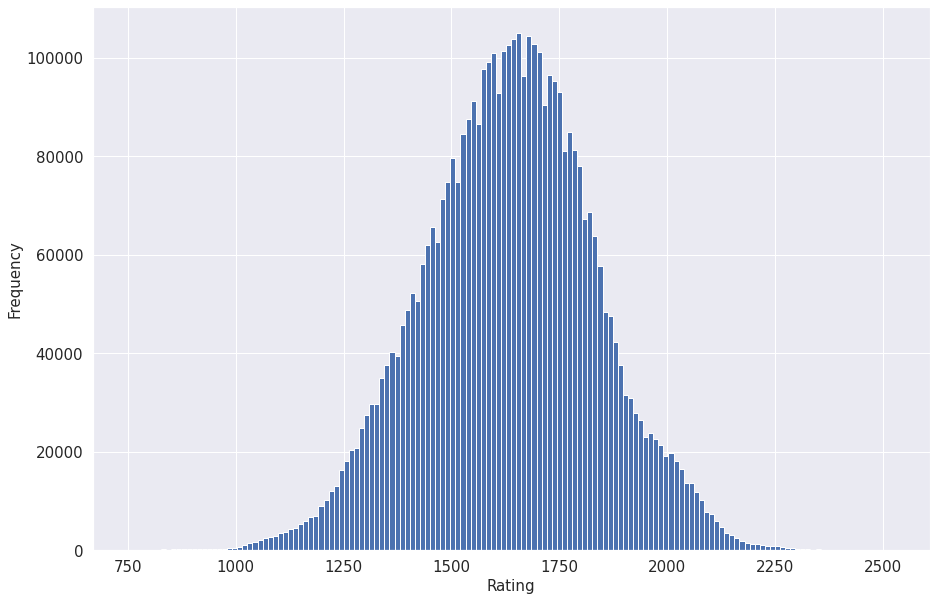

In [ ]:
fig = plt.figure(figsize=(15,10))
_ = plt.hist(blitz_rating_ls, bins=150)
mean_rating = sum(blitz_rating_ls)/len(blitz_rating_ls)
# plt.vlines(mean_rating, 0, 110000)
ax = plt.axes()
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
# ax.annotate('Mean = 1633.95', (mean_rating + 50, 108000))
print(mean_rating)
fig.show()
fig.savefig('rating_dist.jpg')

### Preprocessing data

In [ ]:
''' Call only if changes have been made, otherwise call the cell below to load from Drive'''

# Change to 
# {bullet/blitz/classical}_df_list
game_type = 'Blitz'
df_list = blitz_df_list
all_rating_bins = blitz_rating_bins
bins = blitz_bins

# Get initial data (before transformation)
all_players = []              # player ID

# Activity
all_active_days = []     # Roughly Gaussian
all_avg_active = []           # Skewed right
# all_max_rest = []
all_total_games = []          # Skewed right

# Strategy
all_randomness = []       
all_unweighted_prop_higher = []
all_unweighted_prop_lower = []
all_weighted_prop_higher = []
all_weighted_prop_lower = []

all_average_opponent = []
all_median_opponent = []

all_prop_average_higher = []
all_prop_average_lower = []
all_prop_median_higher = []
all_prop_median_lower = []
all_preferred_opening_1 = []
all_preferred_opening_2 = []
all_preferred_opening_3 = []

# Progress measures
all_avg_rating = []           # Roughly Gaussian with a high peak around 1550
all_rating_SD = []            # Roughly Gaussian, long tail
all_min_rating = []
all_max_rating = []
all_med_rating = []
all_q75 = []
all_q25 = []

# Performance measures
all_unweighted_win_higher = []
all_unweighted_win_lower = []
all_unweighted_win = [] #
all_unweighted_loss_higher = []
all_unweighted_loss_lower = []
all_unweighted_loss = [] #
all_weighted_win_higher = []
all_weighted_win_lower = []
all_weighted_loss_higher = []
all_weighted_loss_lower = []
all_win_averages_higher = []
all_win_averages_lower = []
all_win_averages = [] #
all_loss_averages_higher = []
all_loss_averages_lower = []
all_loss_averages = [] #
all_win_median_higher = []
all_win_median_lower = []
all_win_medians = [] #
all_loss_median_higher = []
all_loss_median_lower = []
all_loss_medians = [] #

i = 0
j = 0
k = 0
for player in nodes_dict:
  sys.stdout.write("\r{0}/{1} Player: {2} - Total Invalid months: {3} | Valid: {4} | Removed: {5}".format(i, len(nodes_dict), player, j, i - k, k))
  # all_players.append(player)
  player_ratings = []
  player_opp_ratings = []
  player_results = []
  player_day_count = []

  month_count = len(df_list)

  for df in df_list:
    try:
      player_ratings = getRatingsPlayer(df, player)
      player_opp_ratings = getOppRatingsPlayer(df, player)
      player_results = getResultsPlayer(df, player)
      player_day_count = getFullDayCount(df, player)
      player_sides = getSidesPlayer(df, player)
      player_openings = getOpeningsPlayer(df, player)
    except:
      k += 1
      break

    if(len(player_opp_ratings) > 10):
      # Only process if player has played more than 10 games for a given month
      all_players.append(player)
    else:
      j += 1
      continue

    # Each period
    games = Games(player, player_ratings, player_opp_ratings, player_results, player_sides, player_openings)
    active_days, avg_active, total_games = getPlayerActivity(player_day_count)
    
    unweighted_prop, average_opponent, median_opponent = getProportionUnweighted(games)
    weighted_prop, prop_average, prop_median = getProportionWeighted(games)

    opening1, opening2, opening3 = games.preferred_openings()
    randomness = getRandomness(games, all_rating_bins, bins)

    start_rating, end_rating, avg_rating, med_rating, q75, q25, min_rating, max_rating, rating_SD = getRatingInfo(games)
    
    unweighted_win, unweighted_loss, _ = getWLDStatsUnweighted(games)
    weighted_win, weighted_loss, win_average, loss_average, win_median, loss_median = getWLDStatsWeighted(games)

    u_prop_h, u_prop_l = unweighted_prop
    w_prop_h, w_prop_l = weighted_prop
    h_avg_p, l_avg_p = prop_average
    h_med_p, l_med_p = prop_median
    u_win_h, u_win_l = unweighted_win
    u_win = u_win_h + u_win_l
    u_loss_h, u_loss_l = unweighted_loss
    u_loss = u_loss_h + u_loss_l
    w_win_h, w_win_l = weighted_win
    w_loss_h, w_loss_l = weighted_loss
    h_avg_win, l_avg_win, avg_win = win_average
    h_avg_loss, l_avg_loss, avg_loss = loss_average
    h_med_win, l_med_win, med_win = win_median
    h_med_loss, l_med_loss, med_loss = loss_median

    all_active_days.append(active_days)
    all_avg_active.append(avg_active)
    all_total_games.append(total_games)

    all_randomness.append(randomness)
    all_avg_rating.append(avg_rating)
    all_rating_SD.append(rating_SD)
    all_min_rating.append(min_rating)
    all_max_rating.append(max_rating)
    all_med_rating.append(med_rating)
    all_q75.append(q75)
    all_q25.append(q25)

    all_unweighted_prop_higher.append(u_prop_h)
    all_unweighted_prop_lower.append(u_prop_l)
    all_weighted_prop_higher.append(w_prop_h)
    all_weighted_prop_lower.append(w_prop_l)

    all_prop_average_higher.append(h_avg_p)
    all_prop_average_lower.append(l_avg_p)
    all_prop_median_higher.append(h_med_p)
    all_prop_median_lower.append(l_med_p)

    all_average_opponent.append(average_opponent)
    all_median_opponent.append(median_opponent)

    all_preferred_opening_1.append(opening1)
    all_preferred_opening_2.append(opening2)
    all_preferred_opening_3.append(opening3)

    all_unweighted_win_higher.append(u_win_h)
    all_unweighted_win_lower.append(u_win_l)
    all_unweighted_win.append(u_win)

    all_unweighted_loss_higher.append(u_loss_h)
    all_unweighted_loss_lower.append(u_loss_l)
    all_unweighted_loss.append(u_loss)

    all_weighted_win_higher.append(w_win_h)
    all_weighted_win_lower.append(w_win_l)
    all_weighted_loss_higher.append(w_loss_h)
    all_weighted_loss_lower.append(w_loss_l)

    all_win_averages_higher.append(h_avg_win)
    all_win_averages_lower.append(l_avg_win)
    all_win_averages.append(avg_win)

    all_loss_averages_higher.append(h_avg_loss)
    all_loss_averages_lower.append(l_avg_loss)
    all_loss_averages.append(avg_loss)

    all_win_median_higher.append(h_med_win)
    all_win_median_lower.append(l_med_win)
    all_win_medians.append(med_win)

    all_loss_median_higher.append(h_med_loss)
    all_loss_median_lower.append(l_med_loss)
    all_loss_medians.append(med_loss)

    sys.stdout.flush()
  i += 1

2312/2313 Player: 11448 - Total Invalid months: 4417 | Valid: 630 | Removed: 1682

In [ ]:
data = [all_active_days,all_avg_active,all_total_games,all_randomness, all_unweighted_prop_higher,all_unweighted_prop_lower,all_weighted_prop_higher,all_weighted_prop_lower,all_average_opponent,all_median_opponent,all_prop_average_higher,all_prop_average_lower,all_prop_median_higher,all_prop_median_lower,all_preferred_opening_1, all_preferred_opening_2,all_preferred_opening_3, all_avg_rating,all_rating_SD,all_min_rating,all_max_rating,all_med_rating, all_q75, all_q25, all_unweighted_win_higher,all_unweighted_win_lower,all_unweighted_win, all_unweighted_loss_higher,all_unweighted_loss_lower, all_unweighted_loss, all_weighted_win_higher,all_weighted_win_lower,all_weighted_loss_higher,all_weighted_loss_lower,all_win_averages_higher,all_win_averages_lower,all_win_averages,all_loss_averages_higher,all_loss_averages_lower,all_loss_averages,all_win_median_higher,all_win_median_lower,all_win_medians,all_loss_median_higher,all_loss_median_lower,all_loss_medians, all_players]
headers = ['active_days','avg_active','total_games','randomness','higher_count','lower_count','weighted_prop_higher','weighted_prop_lower','average_opponent','median_opponent','higher_average','lower_average','higher_median','lower_median', 'opening_1_proportion','opening_2_proportion','opening_3_proportion','avg_rating','rating_SD','min_rating','max_rating', 'median_rating', 'q75_rating', 'q25_rating', 'higher_win_count','lower_win_count','win_count','higher_loss_count','lower_loss_count','loss_count','weighted_win_higher','weighted_win_lower','weighted_loss_higher','weighted_loss_lower','higher_win_average','lower_win_average','win_average','higher_loss_average','lower_loss_average','loss_average','higher_win_median','lower_win_median','win_median','higher_loss_median','lower_loss_median','loss_median',  'player']

df_non_t = pd.DataFrame(data).transpose()
df_non_t.columns = headers

df_non_t.to_csv('{0}processed_data_non_t_{1}.csv'.format(results_folder, game_type), index=False)

# # Map player IDs to ordered numbers
# player_ids = df_non_t.player.unique()
# player_id_map = [i for i in range(1, len(player_ids) + 1)]
# new_player = dict(zip(player_ids, player_id_map))

# df_non_t.player = df_non_t.player.map(new_player)

# player_ids = df_nonstd.player.unique()
# player_id_map = [i for i in range(1, len(player_ids) + 1)]
# new_player = dict(zip(player_ids, player_id_map))

# df_nonstd.player = df_nonstd.player.map(new_player)

In [ ]:
def getRandomnessTest(player_ratings, all_rating_bins, bins):
  max_games = 40000
  rating_bins = getPlayerRating_bins(bins, player_ratings, 40000)
  coef_c = stats.pearsonr(all_rating_bins, rating_bins)
  return abs(coef_c[0])

getRandomnessTest([x for x in range(1500,1600)], blitz_rating_bins, blitz_bins)

0.43394714707717563

## Loading preprocessed data

In [5]:
df_bullet = pd.read_csv('{0}processed_data_non_t_Bullet.csv'.format(results_folder), index_col=False)
df_blitz = pd.read_csv('{0}processed_data_non_t_Blitz.csv'.format(results_folder), index_col=False)
df_classical = pd.read_csv('{0}processed_data_non_t_Classical.csv'.format(results_folder), index_col=False)

# df_blitz_t = pd.read_csv('{0}processed_data_t_Blitz.csv'.format(results_folder), index_col=False)

# # Only get players with 12 months
# df_blitz_cut = df_blitz.groupby("player").filter(lambda x: len(x) == 12)

In [6]:
len(df_classical.player.unique())
df_classical

,active_days,avg_active,total_games,randomness,higher_count,lower_count,weighted_prop_higher,weighted_prop_lower,average_opponent,median_opponent,higher_average,lower_average,higher_median,lower_median,avg_rating,rating_SD,min_rating,max_rating,median_rating,q75_rating,q25_rating,higher_win_count,lower_win_count,win_count,higher_loss_count,lower_loss_count,loss_count,weighted_win_higher,weighted_win_lower,weighted_loss_higher,weighted_loss_lower,higher_win_average,lower_win_average,win_average,higher_loss_average,lower_loss_average,loss_average,higher_win_median,lower_win_median,win_median,higher_loss_median,lower_loss_median,loss_median,preferred_opening_1,preferred_opening_2,preferred_opening_3,player
0,27,7.85185,212,0.25560,134,78,0.66067,0.33933,"1,536.20283","1,536.50000","1,574.00000","1,471.26923","1,579.50000","1,473.50000","1,506.43868",92.60599,1114,1729,"1,500.00000","1,565.25000","1,463.75000",46,48,94,88,30,118,0.19902,0.22270,0.46165,0.11662,"1,563.04348","1,474.77083","1,517.96809","1,579.72727","1,465.66667","1,550.72881","1,565.00000","1,477.50000","1,516.50000","1,590.50000","1,464.00000","1,552.50000",B07,C21,C30,11406
1,28,6.28571,176,0.39435,111,65,0.63210,0.36790,"1,483.13068","1,480.50000","1,523.66667","1,413.90769","1,516.00000","1,451.00000","1,457.80114",81.14087,1082,1671,"1,462.00000","1,495.75000","1,422.50000",46,33,79,65,32,97,0.19871,0.22567,0.43339,0.14223,"1,487.78261","1,401.72727","1,451.83544","1,549.06154","1,426.46875","1,508.61856","1,493.50000","1,447.00000","1,469.00000","1,564.00000","1,455.00000","1,496.00000",B07,D21,D20,11406
2,29,4.31034,125,0.27471,73,52,0.60801,0.39199,"1,551.71200","1,542.00000","1,604.72603","1,477.28846","1,596.00000","1,483.00000","1,529.26400",70.19939,1382,1794,"1,518.00000","1,558.00000","1,482.00000",25,29,54,48,23,71,0.20267,0.25102,0.41153,0.13479,"1,605.68000","1,473.86207","1,534.88889","1,604.22917","1,482.17391","1,564.69014","1,581.00000","1,481.00000","1,534.50000","1,598.00000","1,485.00000","1,569.00000",D20,A21,A45,11406
3,31,5.41935,168,0.31023,113,55,0.68805,0.31195,"1,560.81548","1,560.00000","1,594.78761","1,491.01818","1,589.00000","1,502.00000","1,528.18452",68.25814,1197,1727,"1,527.00000","1,568.00000","1,496.75000",35,34,69,78,21,99,0.21933,0.21926,0.46872,0.09269,"1,591.68571","1,482.23529","1,537.75362","1,596.17949","1,505.23810","1,576.88889","1,587.00000","1,496.50000","1,532.00000","1,591.50000","1,517.00000","1,578.00000",C30,D21,A03,11406
4,28,3.17857,89,0.39088,49,40,0.62875,0.37125,"1,554.23596","1,520.00000","1,611.36735","1,484.25000","1,618.00000","1,486.50000","1,523.44944",81.99027,1354,1768,"1,513.00000","1,549.00000","1,472.00000",18,24,42,31,16,47,0.21478,0.24701,0.41946,0.11875,"1,586.16667","1,484.29167","1,527.95238","1,626.00000","1,474.06250","1,574.27660","1,612.50000","1,484.50000","1,503.00000","1,619.00000","1,480.50000","1,591.00000",A00,C01,D00,11406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18418,16,2.43750,39,0.50213,24,15,0.67536,0.32464,"1,645.10256","1,657.00000","1,676.50000","1,594.86667","1,666.50000","1,635.00000","1,607.87179",116.03032,1253,1793,"1,642.00000","1,667.00000","1,585.50000",8,8,16,16,7,23,0.08237,0.13357,0.59300,0.19106,"1,663.37500","1,605.50000","1,634.43750","1,683.06250","1,582.71429","1,652.52174","1,666.50000","1,621.50000","1,652.50000","1,666.50000","1,635.00000","1,661.00000",C40,B21,C28,2828
18419,18,3.94444,71,0.39287,39,32,0.62001,0.37999,"1,627.21127","1,614.00000","1,677.10256","1,566.40625","1,646.00000","1,581.00000","1,595.28169",124.01535,1257,2053,"1,605.00000","1,643.50000","1,558.00000",14,11,25,25,21,46,0.20445,0.16665,0.41556,0.21334,"1,677.21429","1,588.81818","1,638.32000","1,677.04000","1,554.66667","1,621.17391","1,673.00000","1,578.00000","1,617.00000","1,646.00000","1,584.00000","1,612.50000",B07,C40,B21,

## Progress and Change Datasets



Firstly, we need to determine the optimum window size. We need to maximise the number of players included while ensuring that the quality of the data is good (i.e. minimise the number of players with too few months that may be outliers). In the Blitz dataset, there are 1,617 unique players. We want to retain at least two-thirds of this, meaning we want at least around 1,000 players (1,078 players to be exact). By plotting the following cumulative histogram, showing the number of players with at least $x$ number of months, we can find the minimum number of months a player should have to be included in the next dataset.

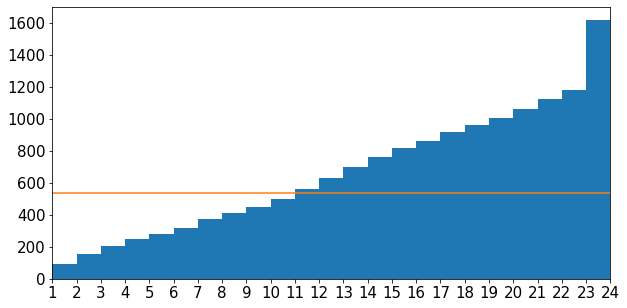

In [7]:
# Number of players in Blitz: 1617
# Retain at least 2/3 == 1078 ~~ 1000
plt.rcParams.update({'font.size': 15})

months = list(df_blitz.player.value_counts().values)
month_counts = [[x, months.count(x)] for x in set(months)]

fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(month_counts)
_, bins, _ = ax.hist(months, cumulative=True, bins=23)
ax.plot([x for x in range(25)], [(1617-1078) for x in range(25)])
ax.set_xlim(1, 24)
ax.set_xticks(bins)
fig.show()

From the above, we can see that to get at least two-thirds of all players (horizontal line at 539 (1,617 - 1,078) shows the lowest point where we will have at least 1,078 players) while having the highest possible minimum number of months required per player, we should take all players with at least 11 months of data.

In [8]:
df = df_blitz.groupby("player").filter(lambda x: len(x) >= 3)

print("Number of unique players: {0}".format(len(df.player.unique())))

Number of unique players: 1463


Add variables prop_higher, calculated as higher_count divided by (higher_count + lower_count) and prop_lower.

In [9]:
df['prop_higher'] = df['higher_count']/(df['higher_count'] + df['lower_count'])
df['prop_lower'] = df['lower_count']/(df['higher_count'] + df['lower_count'])
df['average_difference'] = df['weighted_prop_higher'] + df['weighted_prop_lower']

headers = ['active_days', 'avg_active', 'total_games', 'randomness',
       'higher_count', 'lower_count','prop_higher', 'prop_lower', 'weighted_prop_higher',
       'weighted_prop_lower', 'average_difference', 'average_opponent', 'median_opponent',
       'higher_average', 'lower_average', 'higher_median', 'lower_median',
       'opening_1_proportion', 'opening_2_proportion', 'opening_3_proportion',
       'avg_rating', 'rating_SD', 'min_rating', 'max_rating', 'median_rating',
       'q75_rating', 'q25_rating', 'higher_win_count', 'lower_win_count',
       'win_count', 'higher_loss_count', 'lower_loss_count', 'loss_count',
       'weighted_win_higher', 'weighted_win_lower', 'weighted_loss_higher',
       'weighted_loss_lower', 'higher_win_average', 'lower_win_average',
       'win_average', 'higher_loss_average', 'lower_loss_average',
       'loss_average', 'higher_win_median', 'lower_win_median', 'win_median',
       'higher_loss_median', 'lower_loss_median', 'loss_median', 'player']

df = df[headers]

The Progress dataset will consist of two parts

1.   Activity/Strategy part

This part measures the activity or strategy of the player (e.g. randomness, higher_count). These values are obtained by averaging the respective values across the selected time window. 

2.   Progress part

This part measures the improvement in rating and improvement in performance (win/loss ratio). This is obtained by measuring the difference in the respective variable at the end and the start (e.g. avg_rating at the end of the window minus avg_rating at the start of the window).



In [10]:
strategy_headers = ['randomness','higher_count', 'lower_count', 'weighted_prop_higher',
            'weighted_prop_lower', 'prop_higher','prop_lower', 'average_difference',
            'average_opponent', 'median_opponent',
            'higher_average', 'lower_average', 'higher_median', 'lower_median', 'opening_1_proportion', 'opening_2_proportion', 'opening_3_proportion']

activity_headers = ['active_days', 'avg_active', 'total_games']

act_strat_headers = activity_headers + strategy_headers

rating_headers = ['avg_rating', 'rating_SD', 'min_rating', 'max_rating', 'median_rating',
          'q75_rating', 'q25_rating']

performance_headers = ['higher_win_count', 'lower_win_count',
               'win_count', 'higher_loss_count', 'lower_loss_count', 'loss_count',
               'weighted_win_higher', 'weighted_win_lower', 'weighted_loss_higher',
               'weighted_loss_lower', 'higher_win_average', 'lower_win_average',
               'win_average', 'higher_loss_average', 'lower_loss_average',
               'loss_average', 'higher_win_median', 'lower_win_median', 'win_median',
               'higher_loss_median', 'lower_loss_median', 'loss_median']

progress_headers = rating_headers + performance_headers

In some variables, particularly performance and strategy variables that split into higher and lower, some values may default to zero. This may cause problems when finding the difference or average (e.g. start is 0 by default, end is 1500, difference is +1500 which would be a huge outlier). Therefore, rows should be deleted if any of the variables that may be subject to this equal zero.

In [11]:
nonzero_headers = ['higher_count', 'lower_count','weighted_prop_higher','weighted_prop_lower','higher_average', 'lower_average', 
                   'higher_median', 'lower_median',
                   'higher_win_average', 'lower_win_average','win_average', 
                   'higher_loss_average', 'lower_loss_average','loss_average', 
                   'higher_win_median', 'lower_win_median', 'win_median',
                   'higher_loss_median', 'lower_loss_median', 'loss_median']

for head in nonzero_headers:
  df = df[df[head] != 0]

This creates the progress dataset (`df_progress`). Specify the window size at the top (`window_size`).

The resulting dataset will have activity and strategy variables as averages over the time window and the progress variables as differences between the first and last month 

In [12]:
# Number of months in the window to check progress
window_size = 3

headers = list(df.columns)
ac_head = headers[:len(act_strat_headers)]
prog_head = headers[len(act_strat_headers):][:len(progress_headers)]
# ac_head = act_strat_headers
# prog_head = progress_headers
for i in range(len(prog_head)):
  prog_head[i] = prog_head[i] + '_c'

start_end_head = []
start_end_pairs = []
for head in prog_head:
  start_end_head.append(head + '_start')
  start_end_head.append(head + '_end')
  start_end_pairs.append((head + '_start', head + '_end'))
  
headers = ac_head + start_end_head + prog_head + ['avg_rating','player']

change_headers = df.columns #["{0}_c".format(x) for x in df.columns[:-1]] + ['player']

# df_progress = pd.DataFrame(columns=headers)
# df_complete_change = pd.DataFrame(columns=change_headers)

unique_players = df['player'].unique()
value_counts = df.player.value_counts()

row_index = 0
row_list = []
change_row_list = []

for player in unique_players:
  sys.stdout.write("\rRow: {0}".format(row_index))
  df_player = df.loc[df['player'] == player]
  ls_player = df_player.values.tolist()
  
  month_count = value_counts[player]
  n_windows = month_count // window_size
  if(n_windows == 0):
    continue
  
  # only iterate over enough months to completely fill each window
  # e.g. if window_size = 3, month_count = 10 then n_windows = 3
  # month_count = 3 * 3 = 9

  month_count = n_windows * window_size

  for i in range(0, month_count, window_size):
    # df_progress
    avg_rating = ls_player[i][19]
    variables = ls_player[i][:len(act_strat_headers)]
    player_v = ls_player[i][-1]

    for j in range(1,window_size):
      variables = [(variables[x] + ls_player[j][:len(act_strat_headers)][x]) for x in range(len(variables))]
      avg_rating += ls_player[j][19]

    variables = [x/window_size for x in variables]

    start_progress_variables = ls_player[i][len(act_strat_headers):][:len(progress_headers)]
    end_progress_variables = ls_player[i + window_size - 1][len(act_strat_headers):][:len(progress_headers)]

    for j in range(len(start_progress_variables)):
      variables.append(start_progress_variables[j])
      variables.append(end_progress_variables[j])

    for j in range(len(start_progress_variables)):
      variables.append(end_progress_variables[j] - start_progress_variables[j])

    avg_rating = avg_rating / window_size
    variables.append(avg_rating)
    variables.append(player_v)

    row_list.append(variables)

    start_variables = ls_player[i][:-1]
    end_variables = ls_player[i + window_size - 1][:-1]

    change_vars = [end_variables[i] - start_variables[i] for i in range(len(start_variables))]
    change_vars.append(player_v)

    change_row_list.append(change_vars)
    row_index += 1

  row_index += 1

df_progress = pd.DataFrame(row_list, columns=headers)
df_progress.drop(df_progress[df_progress.player == 'remove'].index, inplace=True)
df_progress.reset_index(inplace=True, drop=True)
# df_progress.drop(['player'], axis=1, inplace=True)

# df_complete_change = pd.DataFrame(change_row_list, columns=change_headers)
# df_complete_change.drop(df_complete_change[df_complete_change.player == 'remove'].index, inplace=True)
# df_complete_change.reset_index(inplace=True, drop=True)
# df_complete_change.drop(['player'], axis=1, inplace=True)

Row: 7972

In [13]:
df_progress.head(5)

,active_days,avg_active,total_games,randomness,higher_count,lower_count,prop_higher,prop_lower,weighted_prop_higher,weighted_prop_lower,average_difference,average_opponent,median_opponent,higher_average,lower_average,higher_median,lower_median,opening_1_proportion,opening_2_proportion,opening_3_proportion,avg_rating_c_start,avg_rating_c_end,rating_SD_c_start,rating_SD_c_end,min_rating_c_start,min_rating_c_end,max_rating_c_start,max_rating_c_end,median_rating_c_start,median_rating_c_end,q75_rating_c_start,q75_rating_c_end,q25_rating_c_start,q25_rating_c_end,higher_win_count_c_start,higher_win_count_c_end,lower_win_count_c_start,lower_win_count_c_end,win_count_c_start,win_count_c_end,...,lower_win_median_c_end,win_median_c_start,win_median_c_end,higher_loss_median_c_start,higher_loss_median_c_end,lower_loss_median_c_start,lower_loss_median_c_end,loss_median_c_start,loss_median_c_end,avg_rating_c,rating_SD_c,min_rating_c,max_rating_c,median_rating_c,q75_rating_c,q25_rating_c,higher_win_count_c,lower_win_count_c,win_count_c,higher_loss_count_c,lower_loss_count_c,loss_count_c,weighted_win_higher_c,weighted_win_lower_c,weighted_loss_higher_c,weighted_loss_lower_c,higher_win_average_c,lower_win_average_c,win_average_c,higher_loss_average_c,lower_loss_average_c,loss_average_c,higher_win_median_c,lower_win_median_c,win_median_c,higher_loss_median_c,lower_loss_median_c,loss_median_c,avg_rating,player
0,25.66667,5.01650,130.66667,0.33330,83.66667,47.00000,0.70126,0.29874,68.25964,-27.46799,40.79165,"1,421.04228","1,430.66667",96.92009,-83.18015,90.00000,-67.16667,0.29809,0.21832,0.15413,"1,347.74576","1,405.34868",30.45953,26.78552,"1,274.00000","1,345.00000","1,395.00000","1,469.00000","1,353.00000","1,406.50000","1,373.00000","1,425.00000","1,327.50000","1,382.75000",18.00000,40.00000,4.00000,32.00000,22.00000,72.00000,...,"1,318.00000","1,418.50000","1,408.00000","1,438.00000","1,496.00000","1,317.00000","1,374.00000","1,436.00000","1,469.50000",57.60292,-3.67401,71.00000,74.00000,53.50000,52.00000,55.25000,22.00000,28.00000,50.00000,19.00000,24.00000,43.00000,-47.77041,183.34779,-337.42284,196.34902,48.95833,-13.84375,-16.15909,59.45606,12.52000,8.12905,60.50000,-10.50000,-10.50000,58.00000,57.00000,33.50000,0.15413,"11,406.00000"
1,27.66667,6.59706,183.00000,0.35302,119.33333,63.66667,0.64464,0.35536,65.02976,-33.79039,31.23936,"1,415.70129","1,431.33333",100.14894,-95.55591,90.33333,-73.16667,0.31417,0.24824,0.14597,"1,360.37963","1,379.04651",34.18799,28.76485,"1,285.00000","1,285.00000","1,444.00000","1,435.00000","1,364.00000","1,381.50000","1,382.25000","1,401.75000","1,332.75000","1,361.00000",54.00000,58.00000,33.00000,42.00000,87.00000,100.00000,...,"1,317.50000","1,400.00000","1,393.50000","1,466.00000","1,508.50000","1,309.50000","1,338.00000","1,443.00000","1,473.00000",18.66688,-5.42315,0.00000,-9.00000,17.50000,19.50000,28.25000,4.00000,9.00000,13.00000,17.00000,12.00000,29.00000,-35.75022,19.73547,7.41494,42.00560,5.05875,44.15152,12.89356,60.57424,24.68449,44.97895,-9.50000,44.50000,-6.50000,42.50000,28.50000,30.00000,0.14597,"11,406.00000"
2,24.66667,7.29229,176.00000,0.37589,116.66667,59.33333,0.65772,0.34228,69.50438,-31.27924,38.22514,"1,423.54685","1,434.66667",104.03083,-90.80515,89.66667,-74.66667,0.29316,0.24729,0.15680,"1,362.95897","1,401.41433",42.43400,42.06026,"1,288.00000","1,295.00000","1,449.00000","1,520.00000","1,356.00000","1,403.00000","1,401.00000","1,435.00000","1,328.00000","1,368.00000",50.00000,84.00000,26.00000,26.00000,76.00000,110.00000,...,"1,389.50000","1,411.00000","1,467.00000","1,473.00000","1,543.00000","1,332.00000","1,398.00000","1,455.00000","1,511.00000",38.45536,-0.37375,7.00000,71.00000,47.00000,34.00000,40.00000,34.00000,0.00000,34.00000,78.00000,14.00000,92.00000,18.13012,-61.53161,109.53051,20.35840,39.63333,69.03846,66.58589,100.34855,55.80417,92.79971,43.00000,72.50000,56.00000,70.00000,66.00000,56.00000,0.15680,"11,406.00000"
3,27.33333,6.05912,165.00000,0.43145,114.33333,

## Variables distributions

### Setup

In [ ]:
norm_data = []
# df = df_progress
# df_progress
norm_headers = df_progress.columns
# norm_headers = ['active_days', 'avg_active', 'total_games',
              # 'randomness', 'prop_higher', 'prop_lower',
              # 'weighted_prop_higher', 'weighted_prop_lower', 
              # 'average_opponent', 'median_opponent', 
              # 'higher_average', 'lower_average', 'higher_median', 'lower_median']
norm_d_head = dict(zip(norm_headers,[i for i in range(0, len(norm_headers))]))
for col in norm_headers:
  norm_data.append(list(df_progress[col]))

# change_data = []
# # df = df_progress
# # df_progress
# change_headers = df_complete_change.columns
# change_d_head = dict(zip(change_headers,[i for i in range(0, len(change_headers))]))
# for col in change_headers:
#   change_data.append(list(df_complete_change[col]))



In [ ]:
df_progress

,active_days,avg_active,total_games,randomness,higher_count,lower_count,prop_higher,prop_lower,weighted_prop_higher,weighted_prop_lower,average_difference,average_opponent,median_opponent,higher_average,lower_average,higher_median,lower_median,opening_1_proportion,opening_2_proportion,opening_3_proportion,avg_rating_c_start,avg_rating_c_end,rating_SD_c_start,rating_SD_c_end,min_rating_c_start,min_rating_c_end,max_rating_c_start,max_rating_c_end,median_rating_c_start,median_rating_c_end,q75_rating_c_start,q75_rating_c_end,q25_rating_c_start,q25_rating_c_end,higher_win_count_c_start,higher_win_count_c_end,lower_win_count_c_start,lower_win_count_c_end,win_count_c_start,win_count_c_end,...,win_median_c_start,win_median_c_end,higher_loss_median_c_start,higher_loss_median_c_end,lower_loss_median_c_start,lower_loss_median_c_end,loss_median_c_start,loss_median_c_end,avg_rating_c,rating_SD_c,min_rating_c,max_rating_c,median_rating_c,q75_rating_c,q25_rating_c,higher_win_count_c,lower_win_count_c,win_count_c,higher_loss_count_c,lower_loss_count_c,loss_count_c,weighted_win_higher_c,weighted_win_lower_c,weighted_loss_higher_c,weighted_loss_lower_c,higher_win_average_c,lower_win_average_c,win_average_c,higher_loss_average_c,lower_loss_average_c,loss_average_c,higher_win_median_c,lower_win_median_c,win_median_c,higher_loss_median_c,lower_loss_median_c,loss_median_c,avg_rating,player,opening_proportion
0,25.66667,5.01650,130.66667,0.33330,83.66667,47.00000,0.70126,0.29874,68.25964,-27.46799,40.79165,"1,421.04228","1,430.66667",96.92009,-83.18015,90.00000,-67.16667,0.29809,0.21832,0.15413,"1,347.74576","1,405.34868",30.45953,26.78552,"1,274.00000","1,345.00000","1,395.00000","1,469.00000","1,353.00000","1,406.50000","1,373.00000","1,425.00000","1,327.50000","1,382.75000",18.00000,40.00000,4.00000,32.00000,22.00000,72.00000,...,"1,418.50000","1,408.00000","1,438.00000","1,496.00000","1,317.00000","1,374.00000","1,436.00000","1,469.50000",57.60292,-3.67401,71.00000,74.00000,53.50000,52.00000,55.25000,22.00000,28.00000,50.00000,19.00000,24.00000,43.00000,-47.77041,183.34779,-337.42284,196.34902,48.95833,-13.84375,-16.15909,59.45606,12.52000,8.12905,60.50000,-10.50000,-10.50000,58.00000,57.00000,33.50000,0.15413,"11,406.00000",0.67054
1,27.66667,6.59706,183.00000,0.35302,119.33333,63.66667,0.64464,0.35536,65.02976,-33.79039,31.23936,"1,415.70129","1,431.33333",100.14894,-95.55591,90.33333,-73.16667,0.31417,0.24824,0.14597,"1,360.37963","1,379.04651",34.18799,28.76485,"1,285.00000","1,285.00000","1,444.00000","1,435.00000","1,364.00000","1,381.50000","1,382.25000","1,401.75000","1,332.75000","1,361.00000",54.00000,58.00000,33.00000,42.00000,87.00000,100.00000,...,"1,400.00000","1,393.50000","1,466.00000","1,508.50000","1,309.50000","1,338.00000","1,443.00000","1,473.00000",18.66688,-5.42315,0.00000,-9.00000,17.50000,19.50000,28.25000,4.00000,9.00000,13.00000,17.00000,12.00000,29.00000,-35.75022,19.73547,7.41494,42.00560,5.05875,44.15152,12.89356,60.57424,24.68449,44.97895,-9.50000,44.50000,-6.50000,42.50000,28.50000,30.00000,0.14597,"11,406.00000",0.70838
2,24.66667,7.29229,176.00000,0.37589,116.66667,59.33333,0.65772,0.34228,69.50438,-31.27924,38.22514,"1,423.54685","1,434.66667",104.03083,-90.80515,89.66667,-74.66667,0.29316,0.24729,0.15680,"1,362.95897","1,401.41433",42.43400,42.06026,"1,288.00000","1,295.00000","1,449.00000","1,520.00000","1,356.00000","1,403.00000","1,401.00000","1,435.00000","1,328.00000","1,368.00000",50.00000,84.00000,26.00000,26.00000,76.00000,110.00000,...,"1,411.00000","1,467.00000","1,473.00000","1,543.00000","1,332.00000","1,398.00000","1,455.00000","1,511.00000",38.45536,-0.37375,7.00000,71.00000,47.00000,34.00000,40.00000,34.00000,0.00000,34.00000,78.00000,14.00000,92.00000,18.13012,-61.53161,109.53051,20.35840,39.63333,69.03846,66.58589,100.34855,55.80417,92.79971,43.00000,72.50000,56.00000,70.00000,66.00000,56.00000,0.15680,"11,406.00000",0.69725
3,27.33333,6.05912,165.00000,0.43145,114.33333,50.66667,0.69659,0.303

In [ ]:
plt.rcParams.update({'font.size': 22})

def plotByBins_X_Value(X, Y, data, n_bins=100):
  argsort_indices = np.argsort(data[X])
  sorted_x = sorted(data[X])

  # n_bins = 200
  n_bin_size = int(len(data[X])/(n_bins - 1))
  x_axis = np.array([int(x/n_bin_size) if int(x/n_bin_size) < n_bins else n_bins - 1 for x in range(0, len(data[X]))])
  y_axis = np.array(data[Y])[argsort_indices]
  current_bin = 0
  new_y = np.zeros(n_bins)
  new_x = np.zeros(n_bins)

  current_count = 0

  second_last = False
  for i, x in enumerate(x_axis):
    if(second_last == False):
      if(x == current_bin):
        new_y[x] += y_axis[i]
        new_x[x] += sorted_x[i]
        current_count += 1
      else:
        if(x == x_axis[-1] - 1):
          second_last = True
          new_x[x - 1] = new_x[x - 1]/current_count
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
        else:
          new_x[x - 1] = new_x[x - 1]/current_count
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
    
    if(second_last):
      new_x[current_bin] += sorted_x[i]
      new_y[current_bin] += y_axis[i]
      current_count += 1

    # if last index/bin
      if(i == len(x_axis) - 1):
        new_x[current_bin] = new_x[current_bin]/current_count
        new_y[current_bin] = new_y[current_bin]/current_count


  # new_x = np.array(list(set(x_axis)))
  
  return new_x[:-1], new_y[:-1]


def plotByBins(X, Y, data, n_bins=100):
  argsort_indices = np.argsort(data[X])
  sorted_x = sorted(data[X])

  # n_bins = 200
  n_bin_size = int(len(data[X])/(n_bins - 1))
  x_axis = np.array([int(x/n_bin_size) if int(x/n_bin_size) < n_bins else n_bins - 1 for x in range(0, len(data[X]))])
  y_axis = np.array(data[Y])[argsort_indices]
  current_bin = 0
  new_y = np.zeros(n_bins)
  current_count = 0

  second_last = False
  for i, x in enumerate(x_axis):
    if(second_last == False):
      if(x == current_bin):
        new_y[x] += y_axis[i]
        current_count += 1
      else:
        if(x == x_axis[-1] - 1):
          second_last = True
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
        else:
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
    
    if(second_last):
      new_y[current_bin] += y_axis[i]
      current_count += 1

    # if last index/bin
      if(i == len(x_axis) - 1):
        new_y[current_bin] = new_y[current_bin]/current_count


  new_x = np.array(list(set(x_axis)))
  
  return new_x[:-1], new_y[:-1]

def lineOfBestFit(x_axis,y_axis):
  m1, b1 = np.polyfit(x_axis, y_axis, 1)
  return m1, b1

def normalise_y(y_axis, y_max):
  return [y/y_max for y in y_axis]

### All: Plot individual variables

In [ ]:
plt.rcParams.update({'font.size': 20})

data = norm_data
d_head = norm_d_head
headers = norm_headers
Y = 0
n = 4
m = 4

fig = plt.figure(figsize=(30,30))

for i in range(n):
  for j in range(m):
    ax = plt.subplot2grid((n,m), (i,j))
    if(Y == len(headers) - 1):
      pass
    else:
      ax.hist(data[Y], bins=150)
      ax.set_title(headers[Y])
      ax.set_xlabel('Value')
      ax.set_ylabel('Frequency')
      Y += 1

plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

plt.show()
fig.savefig("all_plots.jpg")

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f686f1a33b0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,10))
higher = [data[d_head['higher_count']][i]/data[d_head['total_games']][i] for i in range(len(data[0]))]
lower = [data[d_head['lower_count']][i]/data[d_head['total_games']][i] for i in range(len(data[0]))]

ax1.hist(higher, bins=150)
ax1.set_title("higher_proportion")
ax2.hist(lower, bins=150)
ax2.set_title("lower_proportion")

# ax.set_title(headers[Y])
# Y += 1
plt.show()
fig.savefig("higher_lower")

### All: Plot Y against X

In [ ]:
plt.rcParams.update({'font.size': 35})

data = norm_data
d_head = norm_d_head
headers = norm_headers

X_head = 'total_games'
X = d_head[X_head]
print("Plots of Y against {0}".format(headers[X]))

Y = 0
n = 7
m = 7

fig = plt.figure(figsize=(10*m, 10*n))

for i in range(n):
  for j in range(m):
    ax = plt.subplot2grid((n,m), (i,j))
    if(Y == len(data)):
      pass
    else:
      x_axis = np.array(data[X])
      y_axis = np.array(data[Y])
      ax.scatter(x_axis, y_axis, s=[1 for i in range(len(data[X]))])
      ax.set_title(headers[Y])
      Y += 1
plt.show()
fig.savefig("all_against_{0}_change.jpg".format(X_head))

### All: Plot Y against order of X (in bins)

In [ ]:
plt.rcParams.update({'font.size': 35})

data = norm_data
d_head = norm_d_head
headers = norm_headers

X_head = 'avg_rating_c'
X = d_head[X_head]
# argsort_indices = np.argsort(x_data[X])
print("Plots of Y against Order of {0}".format(headers[X]))
plots = []
Y = 0
n = 7
m = 7
fig = plt.figure(figsize=(m*10,n*10))
n_bins = 200

for i in range(n):
  for j in range(m):
    ax = plt.subplot2grid((n,m), (i,j))
    if(Y == len(data)):
      pass
    else:
      ax.set_title(headers[Y])

      blitz_x_axis, blitz_y_axis = plotByBins(X,Y, data, n_bins)
      ax.plot(blitz_x_axis, blitz_y_axis, 'b')

      Y += 1

plt.show()

fig.savefig("all_against_{0}_order {1}.jpg".format(X_head, n_bins))

In [ ]:
plt.rcParams.update({'font.size': 20})

data = norm_data
d_head = norm_d_head
headers = act_strat_headers

X_head = 'avg_rating_c'
X = d_head[X_head]
# argsort_indices = np.argsort(x_data[X])
print("Plots of Y against Order of {0}".format(X_head))

plots = []
Y = 0
n = 5
m = 4
fig = plt.figure(figsize=(m*10,n*10))
n_bins = 200

for i in range(n):
  for j in range(m):
    ax = plt.subplot2grid((n,m), (i,j))
    if(Y == len(headers)):
      ax.set_title("avg_rating")
      blitz_x_axis, blitz_y_axis = plotByBins(X,d_head['avg_rating'], data, n_bins)
      ax.plot(blitz_x_axis, blitz_y_axis, 'b')
      Y += 1
    elif(Y > len(headers)):
      pass
    else:
      ax.set_title(headers[Y])

      blitz_x_axis, blitz_y_axis = plotByBins(X,Y, data, n_bins)
      ax.plot(blitz_x_axis, blitz_y_axis, 'b')

      Y += 1

plt.show()

fig.savefig("act_strat_against_{0}_order {1}.jpg".format(X_head, n_bins))

In [ ]:
plt.rcParams.update({'font.size': 20})

data = norm_data
d_head = norm_d_head
headers = act_strat_headers

X_head = 'avg_rating_c'
X = d_head[X_head]
# argsort_indices = np.argsort(x_data[X])
print("Plots of Y against Order of {0}".format(X_head))

plots = []
Y = 0
n = 5
m = 4
fig = plt.figure(figsize=(m*10,n*10))
n_bins = 200

for i in range(n):
  for j in range(m):
    ax = plt.subplot2grid((n,m), (i,j))
    if(Y == len(headers)):
      ax.set_title("avg_rating")
      blitz_x_axis, blitz_y_axis = plotByBins_X_Value(X,d_head['avg_rating'], data, n_bins)
      ax.plot(blitz_x_axis, blitz_y_axis, 'b')
      Y += 1
    elif(Y > len(headers)):
      pass
    else:
      ax.set_title(headers[Y])

      blitz_x_axis, blitz_y_axis = plotByBins_X_Value(X,Y, data, n_bins)
      ax.plot(blitz_x_axis, blitz_y_axis, 'b')

      Y += 1

plt.show()

fig.savefig("act_strat_against_{0}_order {1} with X values.jpg".format(X_head, n_bins))

### Individual: Plot Y against order of X

In [ ]:
plt.rcParams.update({'font.size': 20})

data = norm_data
d_head = norm_d_head
headers = norm_headers

# header_list = ['win_count_c', 'loss_count_c']

fig, ax = plt.subplots(figsize=(15,10))

X_head = 'avg_rating'
Y_head = 'max_rating_c_start'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'b')

Y_head = 'max_rating_c_end'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'g')

Y_head = 'min_rating_c_start'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'b')

Y_head = 'min_rating_c_end'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'g')



Y_head = 'avg_rating_c_start'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'b')

Y_head = 'avg_rating_c_end'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'g')
# Line of best fit
# m1, b1 = np.polyfit(x_axis, y_axis, 1)
# ax.plot(x_axis, m1*x_axis + b1)
ax.set_title("{0} against order of {1} ({2} bins)".format(Y_head, X_head, n_bins))

# ax.plot(x_axis, [0 for x in x_axis])
# ax.vlines(75, ymin=min(y_axis), ymax=max(y_axis))

plt.show()
fig.savefig("{0} against order of {1} ({2}).jpg".format(Y_head, X_head, n_bins))

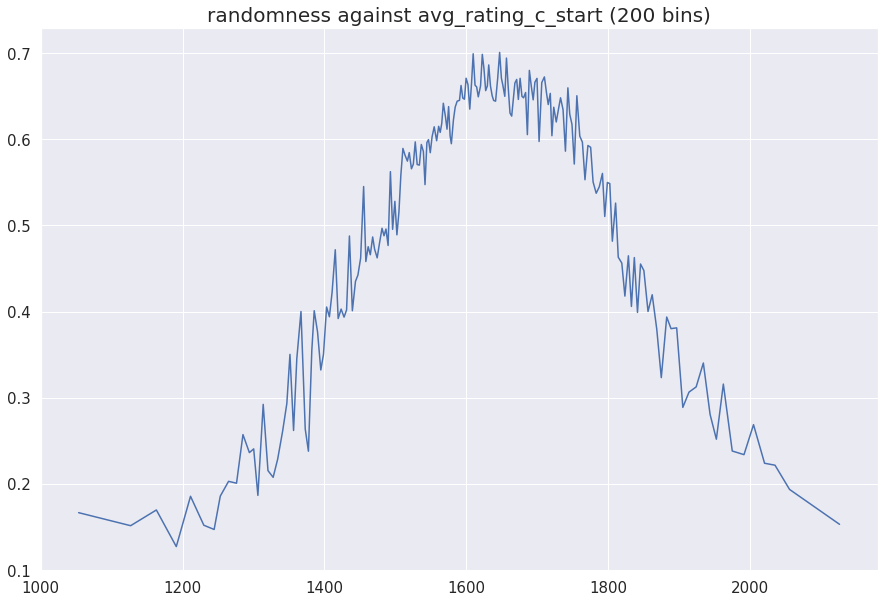

In [ ]:
plt.rcParams.update({'font.size': 20})

data = norm_data
d_head = norm_d_head
headers = norm_headers

# header_list = ['win_count_c', 'loss_count_c']

fig, ax = plt.subplots(figsize=(15,10))

X_head = 'avg_rating_c_start'
Y_head = 'randomness'

X = d_head[X_head]
Y = d_head[Y_head]
n_bins = 200
x_axis, y_axis = plotByBins_X_Value(X,Y, data, n_bins)

ax.plot(x_axis, y_axis, 'b')
# Line of best fit
# m1, b1 = np.polyfit(x_axis, y_axis, 1)
# ax.plot(x_axis, m1*x_axis + b1)
ax.set_title("{0} against {1} ({2} bins)".format(Y_head, X_head, n_bins))

# ax.plot(x_axis, [0 for x in x_axis])
# ax.vlines(75, ymin=min(y_axis), ymax=max(y_axis))

plt.show()
fig.savefig("{0} against {1} ({2} with X values).jpg".format(Y_head, X_head, n_bins))

### Individual: Plot Y against X

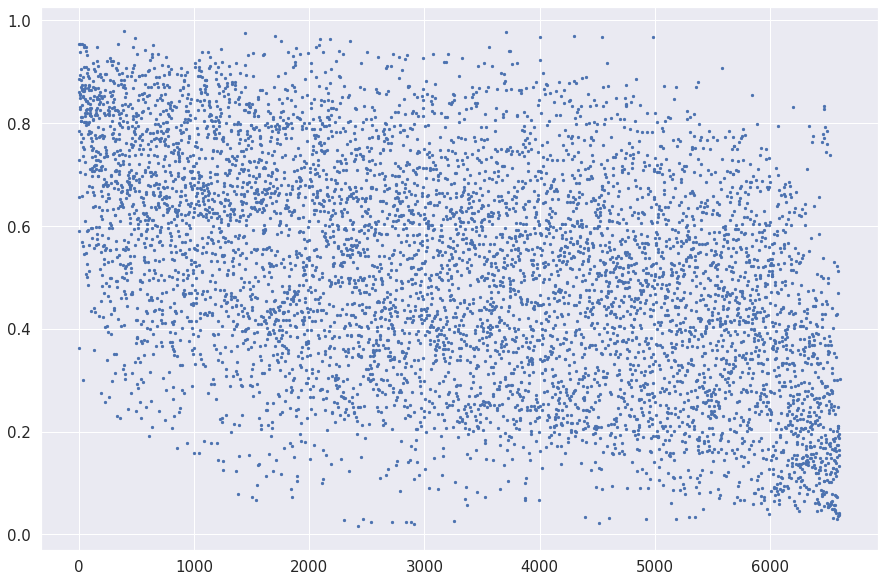

In [ ]:
# def plotByBins(X, Y, data, n_bins=100):

data = norm_data
d_head = norm_d_head
headers = norm_headers

X_head = 'avg_rating_c_start'
Y_head = 'prop_higher'

X = d_head[X_head]
Y = d_head[Y_head]

argsort_indices = np.argsort(data[X])

x_axis = np.array([x for x in range(len(argsort_indices))])
y_axis = np.array(data[Y])[argsort_indices]


fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(x_axis, y_axis, s=5)

# Line of best fit
# m1, b1 = np.polyfit(x_axis, y_axis, 1)
# ax.plot(x_axis, m1*x_axis + b1)


# ax.set_title("{0} against order of {1}".format(Y_head, X_head))

plt.show()
fig.savefig("{0} against order of {1}.jpg".format(Y_head, X_head))

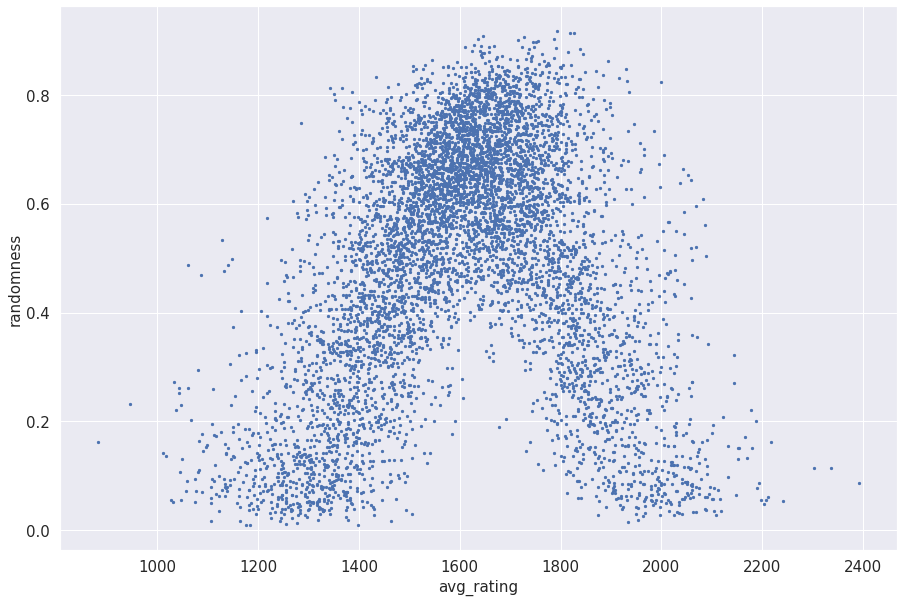

In [ ]:
# def plotByBins(X, Y, data, n_bins=100):

data = norm_data
d_head = norm_d_head
headers = norm_headers

X_head = 'avg_rating_c_start'
Y_head = 'randomness'

X = d_head[X_head]
Y = d_head[Y_head]

argsort_indices = np.argsort(data[X])

x_axis = np.array(sorted(data[X]))
y_axis = np.array(data[Y])[argsort_indices]


fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(x_axis, y_axis, s=5)
ax.set_xlabel('avg_rating')
ax.set_ylabel('randomness')
# Line of best fit
# m1, b1 = np.polyfit(x_axis, y_axis, 1)
# ax.plot(x_axis, m1*x_axis + b1)


# ax.set_title("{0} against order of {1}".format(Y_head, X_head))

plt.show()
fig.savefig("randomness_against_avgrating.jpg")

In [ ]:
# def plotByBins(X, Y, data, n_bins=100):

data = norm_data
d_head = norm_d_head
headers = norm_headers

X_head = 'avg_active'
Y_head = 'avg_active'

X = d_head[X_head]
Y = d_head[Y_head]

argsort_indices = np.argsort(data[X])

x_axis = np.array([x for x in range(len(argsort_indices))])
y_axis = np.array(data[Y])[argsort_indices]


fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x_axis, y_axis, 'b')

# Line of best fit
m1, b1 = np.polyfit(x_axis, y_axis, 1)
ax.plot(x_axis, m1*x_axis + b1)


ax.set_title("{0} against order of {1}".format(Y_head, X_head))

plt.show()
fig.savefig("{0} against order of {1}.jpg".format(Y_head, X_head))

## LDA

In [ ]:
df = df_progress.copy()
# df.drop(['preferred_opening_1','preferred_opening_2','preferred_opening_3', 'index'], axis=1, inplace=True)
label_var = 'avg_rating_c'

lda_headers = ['active_days', 'avg_active', 'total_games'] + [label_var]

# lda_headers = ['randomness', 'prop_higher', 'prop_lower',
#        'weighted_prop_higher', 'weighted_prop_lower', 
#        'average_opponent', 'median_opponent', 
#        'higher_average', 'lower_average', 'higher_median', 'lower_median', 
#        'avg_rating']

lda_headers = ['active_days', 'avg_active', 'total_games',
       'randomness', 'prop_higher',# 'prop_lower',
       'weighted_prop_higher', 'weighted_prop_lower', 'average_difference', 
       'average_opponent', 'median_opponent', 
       'higher_average', 'lower_average', 'higher_median', 'lower_median'] + [label_var]

# lda_headers = ['avg_rating_c', 'rating_SD_c', 'min_rating_c', 'max_rating_c',
#        'median_rating_c', 'q75_rating_c', 'q25_rating_c', 'higher_win_count_c',
#        'lower_win_count_c', 'win_count_c', 'higher_loss_count_c',
#        'lower_loss_count_c', 'loss_count_c', 'weighted_win_higher_c',
#        'weighted_win_lower_c', 'weighted_loss_higher_c',
#        'weighted_loss_lower_c', 'higher_win_average_c', 'lower_win_average_c',
#        'win_average_c', 'higher_loss_average_c', 'lower_loss_average_c',
#        'loss_average_c', 'higher_win_median_c', 'lower_win_median_c',
#        'win_median_c', 'higher_loss_median_c', 'lower_loss_median_c',
#        'loss_median_c', 'avg_rating']

# df_labels = df.loc[:,['avg_rating']].values
df = df.loc[:,lda_headers]
df[label_var] = df[label_var].astype(int)
df.sort_values(by=[label_var],inplace=True, ignore_index=True)

In [ ]:
# https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2
sns.set()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

cols = len(df.columns) - 1
X = df.iloc[:,0:cols].values
y = df.iloc[:,cols].values
# y = [i for i in range(len(X))]
y_label = df.loc[:,[label_var]].values
# y_label = df_labels
# y_label = roundTo50(y_label)

lda = LDA()
X_lda = lda.fit_transform(X, y)
lda_dimensions = X_lda.shape[1]
print("Number of dimensions: {0}".format(lda_dimensions))
pc = [x/sum(lda.explained_variance_ratio_) for x in lda.explained_variance_ratio_]

classes = sorted(df[label_var].value_counts().index)
# classes = df.player.value_counts().index

# Number of months for each player
class_counts = df[label_var].value_counts()

final_X = np.zeros(shape=(len(classes),lda_dimensions))
current_index = 0

# df_rating_class = pd.DataFrame(columns=)
for i, c in enumerate(classes):
  counts = class_counts[c]
  ind = [current_index + j for j in range(counts)]
  current_index += counts

  sys.stdout.write("\rClass {0}, Counts {1} Current Index: {2}".format(c, counts, current_index))

  selected_X = np.array(X_lda)[ind]
  # selected_Y = np.array(y_label)[ind]
  rating_row = np.zeros(shape=(1,lda_dimensions))

  for k in range(lda_dimensions):
    avg_L = 0
    for j in range(counts):
      avg_L += selected_X[j][k]
    avg_L /= counts
    rating_row[0][k] = avg_L

  final_X[i - 1] = rating_row[0]
  sys.stdout.flush()

sys.stdout.write("\r")

Number of dimensions: 13


In [ ]:
# classes = df.progress_class.value_counts().index
values = sorted(df[label_var].value_counts().index)
# classes = df_all.avg_rating.value_counts().index

unique_y = np.unique(y_label)
unique_y = dict(zip(unique_y, [15*i for i in range(len(unique_y))]))
color_y = [unique_y[i[0]] for i in y_label]

final_y = [i for i in values]

labels = [str(i) for i in classes]

norm = plt.Normalize(vmin=0, vmax=max(final_y))
norm_complete = plt.Normalize(vmin=0, vmax=max(y))
cmap = "hot"

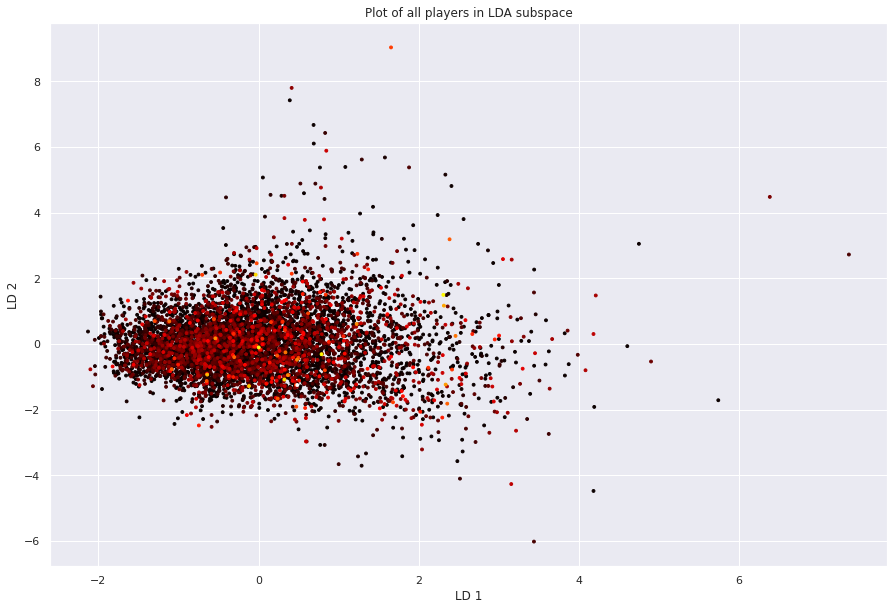

In [ ]:
# Darker = higher ranked (highest rank = 1)

dim1 = 0
dim2 = 1

# fig, axs = plt.subplots(1,2, figsize=(30,10))
# axs[0].scatter(X_lda[:, dim1], X_lda[:, dim2], c=y, norm=norm_complete, cmap=cmap, s=8)
# axs[0].set_title('All points for each player')
# axs[0].set_xlabel("LD {0}".format(dim1 + 1))
# axs[0].set_ylabel("LD {0}".format(dim2+ 1))
# axs[1].scatter(final_X[:, dim1], final_X[:, dim2], c=final_y, norm=norm, cmap=cmap, s=10)
# axs[1].set_title('Mean of all points w.r.t. player')
# axs[1].set_xlabel("LD {0}".format(dim1 + 1))
# axs[1].set_ylabel("LD {0}".format(dim2 + 1))

fig2 = plt.figure(figsize=(15,10))
ax = plt.axes()
plt.scatter(X_lda[:, dim1], X_lda[:, dim2], c=y, norm=norm_complete, cmap=cmap, s=8)
ax.set_title('Plot of all players in LDA subspace')
ax.set_xlabel("LD {0}".format(dim1 + 1))
ax.set_ylabel("LD {0}".format(dim2+ 1))
plt.show()
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
# Set limits of x and y axis of first graph
# axs[0].set_xlim(-10, 10)
# axs[0].set_ylim(-10, 5)

# for i, txt in enumerate(labels):
#   x_coor = final_X[:,dim1][i]
#   y_coor = final_X[:,dim2][i]
#   axs[1].annotate(txt, (x_coor, y_coor))

# plt.show()
fig2.savefig('ldasubspace.png')

In [ ]:
scalings = lda.scalings_

factors = df.columns[:-1]
factors_index = [x for x in range(len(factors))]
new_index = dict(zip(factors_index, factors))

scaling_cols = ['LD{0}'.format(i) for i in range(1,lda_dimensions + 1)]

scaling_df = pd.DataFrame(scalings, columns=scaling_cols)
scaling_df = scaling_df.rename(index=new_index)

ratios = lda.explained_variance_ratio_
trace_index = dict(zip([x for x in range(len(scaling_cols))], scaling_cols))
df_trace = pd.DataFrame(ratios, columns=['explained_variance'])
df_trace = df_trace.rename(index=trace_index)

In [ ]:
scaling_df

,LD1,LD2,LD3,LD4,LD5,LD6,LD7,LD8,LD9,LD10,LD11,LD12,LD13
active_days,-0.11780,-0.05561,-0.00865,-0.09160,-0.10970,0.01007,0.00506,0.03844,-0.06763,-0.05738,0.10704,0.13832,0.14185
avg_active,-0.11897,-0.13724,0.08832,-0.09489,-0.11706,0.21021,-0.11344,0.18995,0.07840,-0.29602,0.01588,0.34406,0.18429
total_games,0.00418,0.00588,-0.00268,0.00342,0.00550,-0.00862,0.00456,-0.00552,-0.00446,0.01057,-0.00661,-0.01560,-0.01204
randomness,-0.89963,-1.42696,1.28595,0.82206,-0.82648,2.29267,-0.60219,-1.38630,1.68767,0.70875,1.09589,-2.77908,-0.57267
prop_higher,2.33206,0.98239,-3.41078,-1.58295,0.83004,9.51978,-0.91421,1.35571,-6.97677,6.09562,-6.06055,0.96395,6.97035
weighted_prop_higher,-0.00666,-0.02548,0.04310,0.03339,0.01694,-0.02995,-0.00518,-0.03519,0.00038,-0.00666,0.01821,0.03151,-0.05004
weighted_prop_lower,-0.02230,0.01232,-0.00775,0.03372,-0.02589,-0.02716,-0.00064,0.03342,0.01699,-0.01588,0.00372,-0.02418,0.01805
average_difference,-0.00949,-0.00283,0.00928,0.02081,-0.00418,-0.01761,-0.00165,0.00171,0.00593,-0.00729,0.00632,0.00044,-0.00767
average_opponent,-0.04672,0.06056,0.01193,0.02317,0.01708,-0.00884,-0.07021,-0.00150,-0.00227,0.01146,0.01016,0.00676,-0.00141
median_opponent,0.04772,-0.06032,-0.01332,-0.02205,-0.01524,0.00867,0.07044,0.00048,-0.00048,-0.01538,-0.00782,-0.00822,0.00209


In [ ]:
df_trace

,explained_variance
LD1,0.11835
LD2,0.10499
LD3,0.10293
LD4,0.09746
LD5,0.08096
LD6,0.07888
LD7,0.07486
LD8,0.06626
LD9,0.06224
LD10,0.05753


In [ ]:
all_weights = abs(scalings*ratios)
weights = []
for i in range(len(all_weights)):
  weights.append(sum(all_weights[i]))

df_weights = pd.DataFrame(weights, columns=['explained_variance'])
df_weights = df_weights.rename(index=new_index)
df_weights

,explained_variance
active_days,0.06970
avg_active,0.14400
total_games,0.00621
randomness,1.23524
prop_higher,3.35792
weighted_prop_higher,0.02308
weighted_prop_lower,0.01885
average_difference,0.00789
average_opponent,0.02459
median_opponent,0.02460


In [ ]:
LDA_cols = ['LD{0}'.format(i) for i in range(1,lda_dimensions + 1)]

df_LDA_full = pd.DataFrame(X_lda,columns=LDA_cols, index=y)
df_LDA_full

df_LDA_mean = pd.DataFrame(final_X, columns=LDA_cols, index=final_y)
df_LDA_mean = df_LDA_mean.loc[:,['LD1', 'LD2', 'LD3']]
df_LDA_mean

,LD1,LD2,LD3
-293,0.26931,0.90769,0.14226
-253,0.90980,-1.36265,0.66644
-244,-0.41466,1.71995,-0.04424
-242,3.58798,0.71965,-0.87530
-239,1.65617,0.49115,-0.89791
...,...,...,...
265,0.32255,-1.08624,1.47732
272,1.54662,0.59048,-0.98062
283,0.00249,-0.10768,0.19844
296,0.48376,-1.25261,1.76672


## Player Classification

Player classification is done in two parts: Activity and Strategy. These two parts are further divided into subparts. Those subparts are measured using a specific few variables, elaborated on in each section.

Firstly, to determine the boundary values for each variable to place them into each class, their minimum, maximum, median, 25th and 75th quartile values need to be found. 

In [14]:
df_progress['opening_proportion'] = df_progress['opening_1_proportion'] + df_progress['opening_2_proportion'] + df_progress['opening_3_proportion']
headers = df_progress.columns
d_head = dict(zip(headers,[i for i in range(0, len(headers))]))

In [15]:
df_progress.head(5)

,active_days,avg_active,total_games,randomness,higher_count,lower_count,prop_higher,prop_lower,weighted_prop_higher,weighted_prop_lower,average_difference,average_opponent,median_opponent,higher_average,lower_average,higher_median,lower_median,opening_1_proportion,opening_2_proportion,opening_3_proportion,avg_rating_c_start,avg_rating_c_end,rating_SD_c_start,rating_SD_c_end,min_rating_c_start,min_rating_c_end,max_rating_c_start,max_rating_c_end,median_rating_c_start,median_rating_c_end,q75_rating_c_start,q75_rating_c_end,q25_rating_c_start,q25_rating_c_end,higher_win_count_c_start,higher_win_count_c_end,lower_win_count_c_start,lower_win_count_c_end,win_count_c_start,win_count_c_end,...,win_median_c_start,win_median_c_end,higher_loss_median_c_start,higher_loss_median_c_end,lower_loss_median_c_start,lower_loss_median_c_end,loss_median_c_start,loss_median_c_end,avg_rating_c,rating_SD_c,min_rating_c,max_rating_c,median_rating_c,q75_rating_c,q25_rating_c,higher_win_count_c,lower_win_count_c,win_count_c,higher_loss_count_c,lower_loss_count_c,loss_count_c,weighted_win_higher_c,weighted_win_lower_c,weighted_loss_higher_c,weighted_loss_lower_c,higher_win_average_c,lower_win_average_c,win_average_c,higher_loss_average_c,lower_loss_average_c,loss_average_c,higher_win_median_c,lower_win_median_c,win_median_c,higher_loss_median_c,lower_loss_median_c,loss_median_c,avg_rating,player,opening_proportion
0,25.66667,5.01650,130.66667,0.33330,83.66667,47.00000,0.70126,0.29874,68.25964,-27.46799,40.79165,"1,421.04228","1,430.66667",96.92009,-83.18015,90.00000,-67.16667,0.29809,0.21832,0.15413,"1,347.74576","1,405.34868",30.45953,26.78552,"1,274.00000","1,345.00000","1,395.00000","1,469.00000","1,353.00000","1,406.50000","1,373.00000","1,425.00000","1,327.50000","1,382.75000",18.00000,40.00000,4.00000,32.00000,22.00000,72.00000,...,"1,418.50000","1,408.00000","1,438.00000","1,496.00000","1,317.00000","1,374.00000","1,436.00000","1,469.50000",57.60292,-3.67401,71.00000,74.00000,53.50000,52.00000,55.25000,22.00000,28.00000,50.00000,19.00000,24.00000,43.00000,-47.77041,183.34779,-337.42284,196.34902,48.95833,-13.84375,-16.15909,59.45606,12.52000,8.12905,60.50000,-10.50000,-10.50000,58.00000,57.00000,33.50000,0.15413,"11,406.00000",0.67054
1,27.66667,6.59706,183.00000,0.35302,119.33333,63.66667,0.64464,0.35536,65.02976,-33.79039,31.23936,"1,415.70129","1,431.33333",100.14894,-95.55591,90.33333,-73.16667,0.31417,0.24824,0.14597,"1,360.37963","1,379.04651",34.18799,28.76485,"1,285.00000","1,285.00000","1,444.00000","1,435.00000","1,364.00000","1,381.50000","1,382.25000","1,401.75000","1,332.75000","1,361.00000",54.00000,58.00000,33.00000,42.00000,87.00000,100.00000,...,"1,400.00000","1,393.50000","1,466.00000","1,508.50000","1,309.50000","1,338.00000","1,443.00000","1,473.00000",18.66688,-5.42315,0.00000,-9.00000,17.50000,19.50000,28.25000,4.00000,9.00000,13.00000,17.00000,12.00000,29.00000,-35.75022,19.73547,7.41494,42.00560,5.05875,44.15152,12.89356,60.57424,24.68449,44.97895,-9.50000,44.50000,-6.50000,42.50000,28.50000,30.00000,0.14597,"11,406.00000",0.70838
2,24.66667,7.29229,176.00000,0.37589,116.66667,59.33333,0.65772,0.34228,69.50438,-31.27924,38.22514,"1,423.54685","1,434.66667",104.03083,-90.80515,89.66667,-74.66667,0.29316,0.24729,0.15680,"1,362.95897","1,401.41433",42.43400,42.06026,"1,288.00000","1,295.00000","1,449.00000","1,520.00000","1,356.00000","1,403.00000","1,401.00000","1,435.00000","1,328.00000","1,368.00000",50.00000,84.00000,26.00000,26.00000,76.00000,110.00000,...,"1,411.00000","1,467.00000","1,473.00000","1,543.00000","1,332.00000","1,398.00000","1,455.00000","1,511.00000",38.45536,-0.37375,7.00000,71.00000,47.00000,34.00000,40.00000,34.00000,0.00000,34.00000,78.00000,14.00000,92.00000,18.13012,-61.53161,109.53051,20.35840,39.63333,69.03846,66.58589,100.34855,55.80417,92.79971,43.00000,72.50000,56.00000,70.00000,66.00000,56.00000,0.15680,"11,406.00000",0.69725
3,27.33333,6.05912,165.00000,0.43145,114.33333,50.66667,0.69659,0.303

**Activity Classification**
Players can be classified by activity in two subparts
1. Frequency
2. Volume

Frequency is measured by `active_days` and volume is measured by `total_games` and `avg_active`. 

**Strategy Classification**
Players can be classified by strategy in three subparts
1. Randomness
2. Balance
3. Opening Consistency

Randomness is measured by `randomness`, balance is measured by `prop_higher` and opening consistency is measured by the sum of `opening_1_proportion`, `opening_2_proportion` and `opening_3_proportion`, called `opening_proportion`.

Only `prop_higher` is used as using higher and lower together is redundant (as they sum to 1 and have a perfect negative correlation)

In [16]:
activity_vars = ['avg_active', 'active_days']
# activity_vars = ['avg_active', 'active_days']

strategy_vars = ['randomness', 'prop_higher'] #, 'average_difference'] #, 'prop_lower', 'opening_proportion']

vars = activity_vars + strategy_vars

data = []
for var in vars:
  data.append(df_progress[var].to_list())

q25s = []
q50s = []
q75s = []

for d in data:
  q75, q50, q25 = np.percentile(d, [75,50,25])
  q25s.append(q25)
  q50s.append(q50)
  q75s.append(q75)

df_class = df_progress.copy()
df_class = df_class[vars]

Each variable for each month is given a value 0 if the value falls below the 25th percentile, 1 if it falls between the 25th and 75th percentile and 2 if it is above the 75th percentile. These are then concatenated to form a number that is unique to each class

e.g.
1, 2, 1, 0, 2, 1 forms the class 121021


In [17]:
for i, var in enumerate(vars):
  mask = df_class[var].to_list()
  for j, val in enumerate(mask):
    if(val < q25s[i]):
      mask[j] = 0
    elif(val < q75s[i]):
      mask[j] = 1
    else:
      mask[j] = 2
  df_class[var] = mask

individual_classes = [df_class[var].astype(str) for var in vars] #['active_days', 'prop_higher']]
class_vals = individual_classes[0]
for i, val in enumerate(individual_classes):
  if(i == 0):
    pass
  else:
    class_vals += val

activity_vals = class_vals.to_list()
strategy_vals = [val[2:] for val in activity_vals]
activity_vals = [val[:2] for val in activity_vals]
df_class['activity_class'] = activity_vals
df_class['strategy_class'] = strategy_vals

individual_classes = [df_class[var].astype(str) for var in ['active_days', 'prop_higher']]
class_vals = individual_classes[0]
for i, val in enumerate(individual_classes):
  if(i == 0):
    pass
  else:
    class_vals += val


df_class['data_class'] = class_vals
df_class['avg_rating'] = df_progress['avg_rating_c_end']

In [18]:
df_class

,avg_active,active_days,randomness,prop_higher,activity_class,strategy_class,data_class,avg_rating
0,1,2,0,2,12,02,22,"1,405.34868"
1,1,2,1,1,12,11,21,"1,379.04651"
2,1,2,1,1,12,11,21,"1,401.41433"
3,1,2,1,2,12,12,22,"1,391.33766"
4,1,2,1,2,12,12,22,"1,403.24229"
...,...,...,...,...,...,...,...,...
6596,0,0,1,0,00,10,00,"1,652.86842"
6597,0,1,1,0,01,10,10,"1,646.12903"
6598,1,0,1,1,10,11,01,"1,719.65169"
6599,1,0,1,1,10,11,01,"1,496.38636"


### Plots of player classes

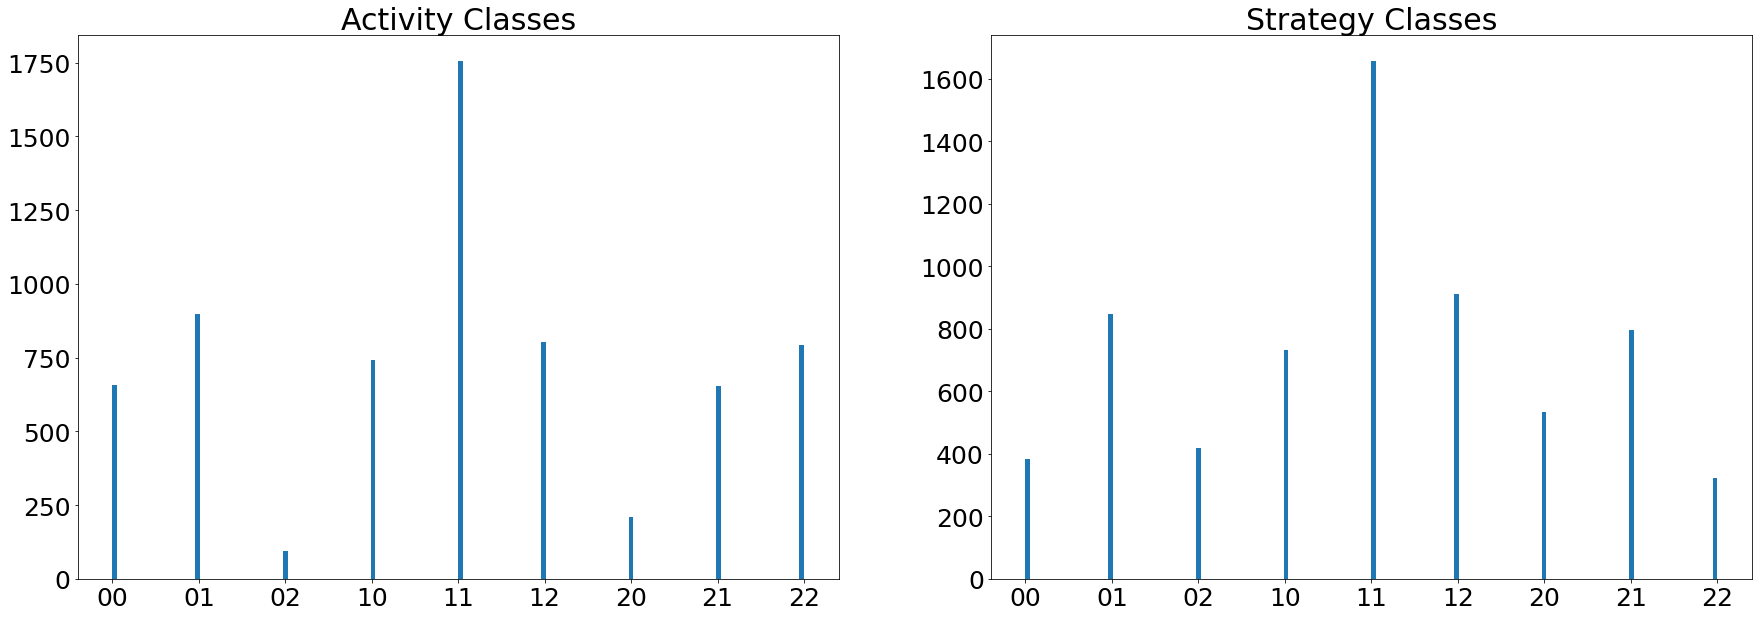

In [19]:
plt.rcParams.update({'font.size': 25})

fig, ax = plt.subplots(1,2, figsize=(30,10))
ax[0].hist(sorted(df_class.activity_class.to_list()), bins=150)
ax[0].set_title("Activity Classes")
ax[1].hist(sorted(df_class.strategy_class.to_list()), bins=150)
ax[1].set_title("Strategy Classes")
plt.show()

In [20]:
df_class.data_class.value_counts()

11    1649
01     912
12     848
10     807
21     739
20     489
22     461
00     354
02     342
Name: data_class, dtype: int64

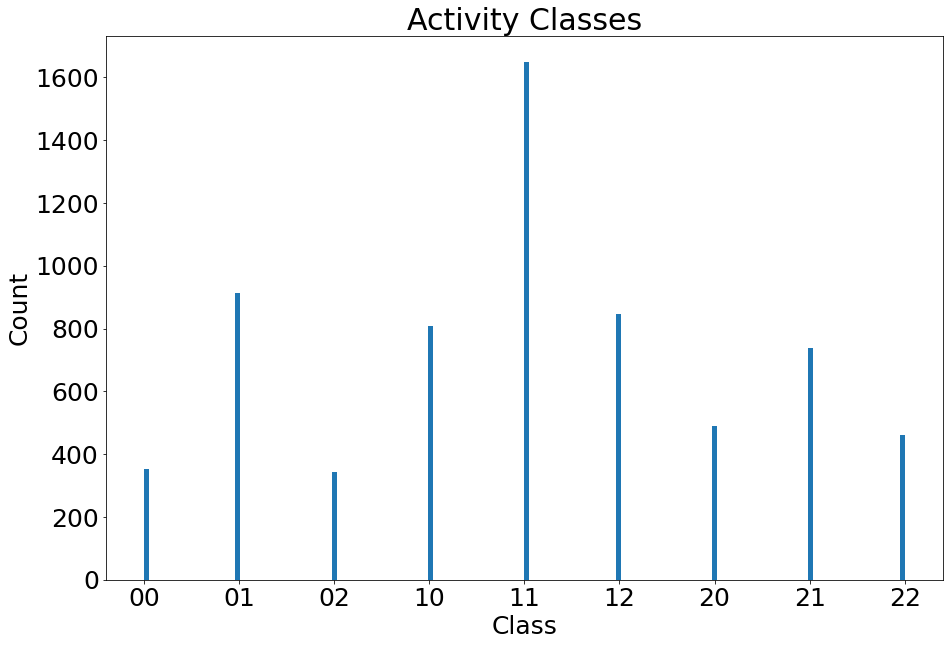

In [21]:
# plt.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(15,10))
ax = plt.axes()
ax.hist(sorted(df_class.data_class.to_list()), bins=150)
ax.set_title("Activity Classes")
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
# ax[1].hist(sorted(df_class.strategy_class.to_list()), bins=150)
# ax[1].set_title("Strategy Classes")
plt.show()
fig.savefig('activity_classes.png')

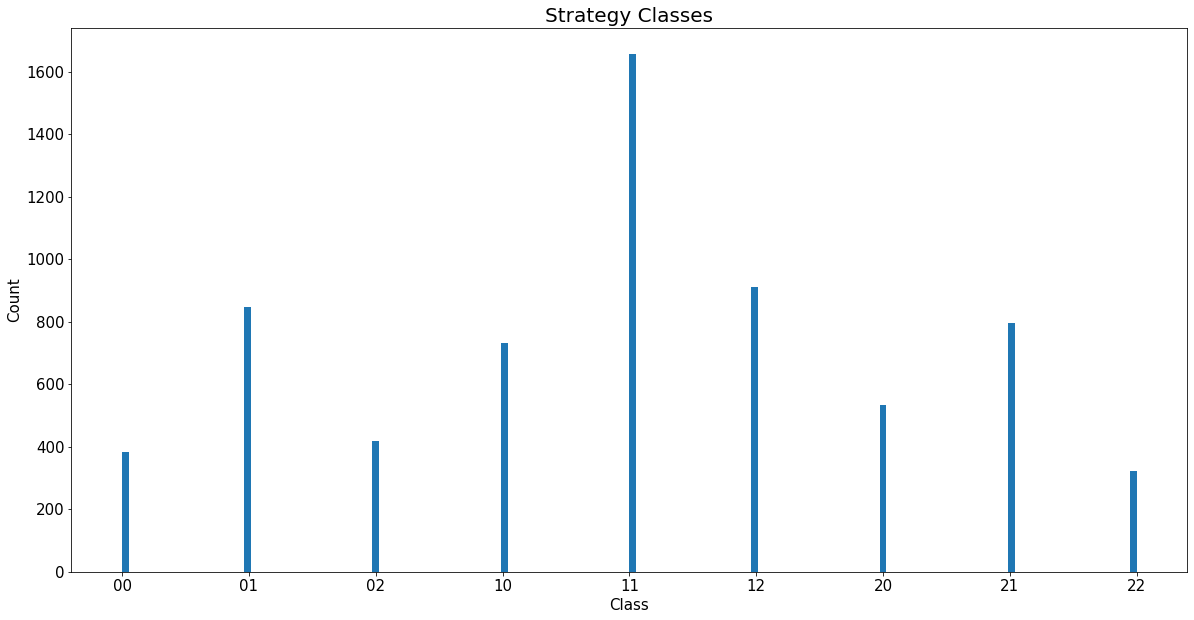

In [22]:
# plt.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(20,10))
ax = plt.axes()
ax.hist(sorted(df_class.strategy_class.to_list()), bins=150)
ax.set_title("Strategy Classes")
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

plt.show()
fig.savefig('strategy_classes.png')

### Interpreting the classes

### Labeled progress dataset

In [23]:
# change_headers = ["{0}_c".format(head) for head in progress_headers]

df_labeled_progress = df_progress[start_end_head]

all_class_map = dict(zip(sorted(df_class['data_class'].unique()),[x for x in range(1, len(df_class['data_class'].unique()) + 1)]))
class_reverse_map = dict(zip([x for x in range(1, len(df_class['data_class'].unique()) + 1)], sorted(df_class['data_class'].unique())))

data_class = df_class['data_class'].to_list()
data_class = [all_class_map[x] for x in data_class]

act_class_map = dict(zip(sorted(df_class['activity_class'].unique()),[x for x in range(1, len(df_class['activity_class'].unique()) + 1)]))
act_reverse_map = dict(zip([x for x in range(1, len(df_class['activity_class'].unique()) + 1)], sorted(df_class['activity_class'].unique())))

act_class = df_class['activity_class'].to_list()
act_class = [act_class_map[x] for x in act_class]

strat_class_map = dict(zip(sorted(df_class['strategy_class'].unique()),[x for x in range(1, len(df_class['strategy_class'].unique()) + 1)]))
strat_reverse_map = dict(zip([x for x in range(1, len(df_class['strategy_class'].unique()) + 1)], sorted(df_class['strategy_class'].unique())))

strat_class = df_class['strategy_class'].to_list()
strat_class = [strat_class_map[x] for x in strat_class]

for col in vars:
  df_labeled_progress[col] = df_class[col]

df_labeled_progress['act_class'] = act_class
df_labeled_progress['strat_class'] = strat_class
df_labeled_progress['data_class'] = data_class


df_labeled_progress.head(5)

,avg_rating_c_start,avg_rating_c_end,rating_SD_c_start,rating_SD_c_end,min_rating_c_start,min_rating_c_end,max_rating_c_start,max_rating_c_end,median_rating_c_start,median_rating_c_end,q75_rating_c_start,q75_rating_c_end,q25_rating_c_start,q25_rating_c_end,higher_win_count_c_start,higher_win_count_c_end,lower_win_count_c_start,lower_win_count_c_end,win_count_c_start,win_count_c_end,higher_loss_count_c_start,higher_loss_count_c_end,lower_loss_count_c_start,lower_loss_count_c_end,loss_count_c_start,loss_count_c_end,weighted_win_higher_c_start,weighted_win_higher_c_end,weighted_win_lower_c_start,weighted_win_lower_c_end,weighted_loss_higher_c_start,weighted_loss_higher_c_end,weighted_loss_lower_c_start,weighted_loss_lower_c_end,higher_win_average_c_start,higher_win_average_c_end,lower_win_average_c_start,lower_win_average_c_end,win_average_c_start,win_average_c_end,higher_loss_average_c_start,higher_loss_average_c_end,lower_loss_average_c_start,lower_loss_average_c_end,loss_average_c_start,loss_average_c_end,higher_win_median_c_start,higher_win_median_c_end,lower_win_median_c_start,lower_win_median_c_end,win_median_c_start,win_median_c_end,higher_loss_median_c_start,higher_loss_median_c_end,lower_loss_median_c_start,lower_loss_median_c_end,loss_median_c_start,loss_median_c_end,avg_active,active_days,randomness,prop_higher,act_class,strat_class,data_class
0,"1,347.74576","1,405.34868",30.45953,26.78552,"1,274.00000","1,345.00000","1,395.00000","1,469.00000","1,353.00000","1,406.50000","1,373.00000","1,425.00000","1,327.50000","1,382.75000",18.00000,40.00000,4.00000,32.00000,22.00000,72.00000,36.00000,55.00000,1.00000,25.00000,37.00000,80.00000,441.35593,393.58553,88.47458,271.82237,881.94915,544.52632,22.32203,218.67105,"1,446.66667","1,495.62500","1,305.00000","1,291.15625","1,420.90909","1,404.75000","1,445.41667","1,504.87273","1,317.00000","1,329.52000","1,441.94595","1,450.07500","1,439.50000","1,500.00000","1,328.50000","1,318.00000","1,418.50000","1,408.00000","1,438.00000","1,496.00000","1,317.00000","1,374.00000","1,436.00000","1,469.50000",1,2,0,2,6,3,9
1,"1,360.37963","1,379.04651",34.18799,28.76485,"1,285.00000","1,285.00000","1,444.00000","1,435.00000","1,364.00000","1,381.50000","1,382.25000","1,401.75000","1,332.75000","1,361.00000",54.00000,58.00000,33.00000,42.00000,87.00000,100.00000,107.00000,124.00000,22.00000,34.00000,129.00000,158.00000,366.03704,330.28682,191.45833,211.19380,728.71296,736.12791,131.87037,173.87597,"1,464.14815","1,469.20690","1,253.18182","1,297.33333","1,384.12644","1,397.02000","1,471.04673","1,531.62097","1,294.72727","1,319.41176","1,440.97674","1,485.95570","1,445.50000","1,436.00000","1,273.00000","1,317.50000","1,400.00000","1,393.50000","1,466.00000","1,508.50000","1,309.50000","1,338.00000","1,443.00000","1,473.00000",1,2,1,1,6,5,8
2,"1,362.95897","1,401.41433",42.43400,42.06026,"1,288.00000","1,295.00000","1,449.00000","1,520.00000","1,356.00000","1,403.00000","1,401.00000","1,435.00000","1,328.00000","1,368.00000",50.00000,84.00000,26.00000,26.00000,76.00000,110.00000,103.00000,181.00000,16.00000,30.00000,119.00000,211.00000,377.35897,395.48910,171.00513,109.47352,784.32308,893.85358,108.92821,129.28660,"1,471.70000","1,511.33333","1,282.53846","1,351.57692","1,406.98684","1,473.57273","1,484.88350","1,585.23204","1,327.56250","1,383.36667","1,463.73109","1,556.53081","1,457.00000","1,500.00000","1,317.00000","1,389.50000","1,411.00000","1,467.00000","1,473.00000","1,543.00000","1,332.00000","1,398.00000","1,455.00000","1,511.00000",1,2,1,1,6,5,8
3,"1,380.74074","1,391.33766",24.64477,31.54367,"1,318.00000","1,326.00000","1,444.00000","1,454.00000","1,377.00000","1,387.00000","1,395.75000","1,416.75000","1,365.00000","1,367.00000",40.00000,33.00000,10.00000,4.00000,50.00000,37.00000,106.00000,114.00000,6.00000,3.00000,112.00000,117.00000,369.76543,337.81818,82.99383,32.87013,"1,006.69136","1,196.05844",49.95062,24.57143,"1,497.55000","1,576.48485","1,344.50000","1,265.50000","1,46

### Plots


In [24]:
# fig, ax = plt.subplots(figsize=(20,10))
# X = df_labeled_progress['data_class']
# Y = df_labeled_progress['avg_rating_c'] #/(df_labeled_progress['win_count_c'] + df_labeled_progress['loss_count_c'])

# avg_Y = np.zeros(len(set(X)))
# Y_counts = np.zeros(len(set(X)))
# avg_X = np.array(sorted(list(set(X))))

# for i, x in enumerate(X):
#   x_ind = x - 1
#   avg_Y[x - 1] = avg_Y[x - 1] + Y[i]
#   Y_counts[x_ind] += 1

# for i, y in enumerate(avg_Y):
#   avg_Y[i] = y/Y_counts[i]

# # ax.scatter(X,Y, s=1)
# ax.scatter(avg_X, avg_Y)
# all_avg_pairs = dict(zip(avg_X, avg_Y))

# # ax.set_ylim(-100,100)
# ax.hlines(0, xmin=0, xmax=max(X))
# fig.show()

In [25]:
# fig, ax = plt.subplots(figsize=(20,10))
# X = df_labeled_progress['act_class']
# Y = df_labeled_progress['avg_rating_c'] #/(df_labeled_progress['win_count_c'] + df_labeled_progress['loss_count_c'])

# avg_Y = np.zeros(len(set(X)))
# Y_counts = np.zeros(len(set(X)))
# avg_X = np.array(sorted(list(set(X))))

# for i, x in enumerate(X):
#   x_ind = x - 1
#   avg_Y[x - 1] = avg_Y[x - 1] + Y[i]
#   Y_counts[x_ind] += 1

# for i, y in enumerate(avg_Y):
#   avg_Y[i] = y/Y_counts[i]

# act_avg_pairs = dict(zip(avg_X, avg_Y))
# # ax.scatter(X,Y, s=1)
# ax.scatter(avg_X, avg_Y)
# # ax.set_ylim(-20,20)
# ax.hlines(0, xmin=0, xmax=max(X))
# fig.show()

In [26]:
# fig, ax = plt.subplots(figsize=(20,10))
# X = df_labeled_progress['strat_class']
# Y = df_labeled_progress['avg_rating_c'] #/(df_labeled_progress['win_count_c'] + df_labeled_progress['loss_count_c'])

# avg_Y = np.zeros(len(set(X)))
# Y_counts = np.zeros(len(set(X)))
# avg_X = np.array(sorted(list(set(X))))

# for i, x in enumerate(X):
#   x_ind = x - 1
#   avg_Y[x - 1] = avg_Y[x - 1] + Y[i]
#   Y_counts[x_ind] += 1

# for i, y in enumerate(avg_Y):
#   avg_Y[i] = y/Y_counts[i]

# # ax.scatter(X,Y, s=1)
# ax.scatter(avg_X, avg_Y)
# strat_avg_pairs = dict(zip(avg_X, avg_Y))

# # ax.set_ylim(-20,20)
# ax.hlines(0, xmin=0, xmax=max(X))
# fig.show()

In [27]:
# sorted_pairs = sorted(all_avg_pairs.items(), key=lambda item: item[1], reverse=True)
# # sorted_pairs

### To create a ranking dataset

In [28]:
def rankingDataset(original_df, columns):
  df = original_df.copy()

  # columns = list(df.columns)[:-5]

  rankings = np.zeros((len(df)))

  for col in columns:
    ratings = df[col].to_list()
    sorted_ratings = sorted(ratings, reverse=True)
    sorted_count = Counter(sorted_ratings)
    order = dict(zip(sorted_ratings, [x for x in range(1, len(ratings) + 1)]))
    indices = []
    for x in ratings:
      if(sorted_count[x] > 1):
        indices.append(order[x] - (sorted_count[x] - 1))
        sorted_count[x] -= 1
      else:
        indices.append(order[x])

    rankings = indices

    ranking_col = [rankings[j] for j in range(len(df))]
    r_col = col + '_rank'
    df[r_col] = ranking_col

  return df

### Plot by Bins functions


In [29]:
plt.rcParams.update({'font.size': 22})

def plotByBins_X_Value(X, Y, n_bins=100):
  argsort_indices = np.argsort(X)
  sorted_x = sorted(X)

  # n_bins = 200
  n_bin_size = int(len(X)/(n_bins - 1))
  x_axis = np.array([int(x/n_bin_size) if int(x/n_bin_size) < n_bins else n_bins - 1 for x in range(0, len(X))])
  y_axis = np.array(Y)[argsort_indices]
  current_bin = 0
  new_y = np.zeros(n_bins)
  new_x = np.zeros(n_bins)

  current_count = 0

  second_last = False
  for i, x in enumerate(x_axis):
    if(second_last == False):
      if(x == current_bin):
        new_y[x] += y_axis[i]
        new_x[x] += sorted_x[i]
        current_count += 1
      else:
        if(x == x_axis[-1] - 1):
          second_last = True
          new_x[x - 1] = new_x[x - 1]/current_count
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
        else:
          new_x[x - 1] = new_x[x - 1]/current_count
          new_y[x - 1] = new_y[x - 1]/current_count
          current_bin = x
          current_count = 0
    
    if(second_last):
      new_x[current_bin] += sorted_x[i]
      new_y[current_bin] += y_axis[i]
      current_count += 1

    # if last index/bin
      if(i == len(x_axis) - 1):
        new_x[current_bin] = new_x[current_bin]/current_count
        new_y[current_bin] = new_y[current_bin]/current_count


  # new_x = np.array(list(set(x_axis)))
  
  return new_x[:-1], new_y[:-1]

def lineOfBestFit(x_axis,y_axis):
  m1, b1 = np.polyfit(x_axis, y_axis, 1)
  return m1, b1

def normalise_y(y_axis, y_max):
  return [y/y_max for y in y_axis]

### Labeled Progress Dataset (average)

This dataset contains the average of progress data for each player class

In [30]:
row_list = []
for data_class in df_labeled_progress.data_class.unique():
  temp_df = df_labeled_progress.loc[df_labeled_progress['data_class'] == data_class]
  count = len(temp_df)
  row = temp_df.mean(axis=0).to_list()
  row.append(count)
  row_list.append(row)

columns = list(df_labeled_progress.columns) + ['count']

# prog_vars_keep = ['avg_rating','win_count','loss_count','win_average','loss_average']
prog_vars_keep = ['avg_rating','rating_SD','min_rating','max_rating','median_rating','q75_rating','q25_rating','higher_win_count','lower_win_count','win_count','higher_loss_count','lower_loss_count','loss_count','weighted_win_higher','weighted_win_lower','weighted_loss_higher','weighted_loss_lower','higher_win_average','lower_win_average','win_average','higher_loss_average','lower_loss_average','loss_average','higher_win_median','lower_win_median','win_median','higher_loss_median','lower_loss_median','loss_median']
start_heads = ["{0}_c_start".format(var) for var in prog_vars_keep]
end_heads = ["{0}_c_end".format(var) for var in prog_vars_keep]
class_heads = ['avg_active','active_days','randomness', 'prop_higher', 'act_class', 'strat_class', 'data_class']

# keep_columns = ['avg_rating_c',
#  'win_count_c',
#  'loss_count_c',
#  'win_average_c',
#  'loss_average_c',
#  'avg_active', 
#  'total_games', # comment if necessary
#  'active_days',
#  'randomness', 
#  'prop_higher',
#  'act_class',
#  'strat_class',
#  'data_class',
#  'count']

df_labeled_progress_avg = pd.DataFrame(row_list, columns=columns)
# df_cut = df_labeled_progress_avg[keep_columns]

df_start = df_labeled_progress[start_heads + class_heads]
df_end = df_labeled_progress[end_heads + class_heads]


In [31]:
df_start.columns

Index(['avg_rating_c_start', 'rating_SD_c_start', 'min_rating_c_start',
       'max_rating_c_start', 'median_rating_c_start', 'q75_rating_c_start',
       'q25_rating_c_start', 'higher_win_count_c_start',
       'lower_win_count_c_start', 'win_count_c_start',
       'higher_loss_count_c_start', 'lower_loss_count_c_start',
       'loss_count_c_start', 'weighted_win_higher_c_start',
       'weighted_win_lower_c_start', 'weighted_loss_higher_c_start',
       'weighted_loss_lower_c_start', 'higher_win_average_c_start',
       'lower_win_average_c_start', 'win_average_c_start',
       'higher_loss_average_c_start', 'lower_loss_average_c_start',
       'loss_average_c_start', 'higher_win_median_c_start',
       'lower_win_median_c_start', 'win_median_c_start',
       'higher_loss_median_c_start', 'lower_loss_median_c_start',
       'loss_median_c_start', 'avg_active', 'active_days', 'randomness',
       'prop_higher', 'act_class', 'strat_class', 'data_class'],
      dtype='object')

In [32]:
# df_to_use = df_cut

# # norm_data = []
# # norm_headers = df_to_use.columns
# # norm_d_head = dict(zip(norm_headers,[i for i in range(0, len(norm_headers))]))
# # for col in norm_headers:
# #   norm_data.append(list(df_to_use[col]))

df_start['win_prop_c_start'] = df_start['win_count_c_start']/(df_start['win_count_c_start'] + df_start['loss_count_c_start'])
start_df = rankingDataset(df_start, list(df_start.columns[:-7]) + ['win_prop_c_start'])
start_data = []
start_headers = start_df.columns
start_d_head = dict(zip(start_headers,[i for i in range(0, len(start_headers))]))
for col in start_headers:
  start_data.append(list(start_df[col]))
# start_df['win_prop_start'] = start_df['win_count_start']/(start_df['win_count_start'] + start_df['loss_count_start'])

df_end['win_prop_c_end'] = df_end['win_count_c_end']/(df_end['win_count_c_end'] + df_end['loss_count_c_end'])
end_df = rankingDataset(df_end, list(df_end.columns[:-7]) + ['win_prop_c_end'])
end_data = []
end_headers = end_df.columns
end_d_head = dict(zip(end_headers,[i for i in range(0, len(end_headers))]))
for col in end_headers:
  end_data.append(list(end_df[col]))


In [33]:
df_start.columns[:-7]

Index(['avg_rating_c_start', 'rating_SD_c_start', 'min_rating_c_start',
       'max_rating_c_start', 'median_rating_c_start', 'q75_rating_c_start',
       'q25_rating_c_start', 'higher_win_count_c_start',
       'lower_win_count_c_start', 'win_count_c_start',
       'higher_loss_count_c_start', 'lower_loss_count_c_start',
       'loss_count_c_start', 'weighted_win_higher_c_start',
       'weighted_win_lower_c_start', 'weighted_loss_higher_c_start',
       'weighted_loss_lower_c_start', 'higher_win_average_c_start',
       'lower_win_average_c_start', 'win_average_c_start',
       'higher_loss_average_c_start', 'lower_loss_average_c_start',
       'loss_average_c_start', 'higher_win_median_c_start',
       'lower_win_median_c_start', 'win_median_c_start',
       'higher_loss_median_c_start', 'lower_loss_median_c_start',
       'loss_median_c_start', 'avg_active'],
      dtype='object')

In [34]:
# plt.rcParams.update({'font.size': 10})

# df_cut = end_df

# data_class = 'randomness'
# df_0 = df_cut.loc[df_cut[data_class] == 0]
# df_1 = df_cut.loc[df_cut[data_class] == 1]
# df_2 = df_cut.loc[df_cut[data_class] == 2]

# bins = 100
# var = 'avg_rating_c_end'
# data_classes = vars
# for data_class in data_classes:

#   # data_class = 'randomness'
#   df_0 = df_cut.loc[df_cut[data_class] == 0]
#   df_1 = df_cut.loc[df_cut[data_class] == 1]
#   df_2 = df_cut.loc[df_cut[data_class] == 2]

#   fig, ax = plt.subplots(1, 3, figsize=(15,3))

#   # ax[0].hist(df_0[var].to_list(), bins=bins)
#   # ax[1].hist(df_1[var].to_list(), bins=bins)
#   # ax[2].hist(df_2[var].to_list(), bins=bins)

#   ax[0].plot(sorted(df_0[var].to_list()))
#   ax[1].plot(sorted(df_1[var].to_list()))
#   ax[2].plot(sorted(df_2[var].to_list()))


#   ax[0].set_title("{0}, class {1}, value {2}".format(var, data_class, 0))
#   ax[1].set_title("{0}, class {1}, value {2}".format(var, data_class, 1))
#   ax[2].set_title("{0}, class {1}, value {2}".format(var, data_class, 2))


# plt.show()


In [35]:
# plt.rcParams.update({'font.size': 15})

# # start_df
# # end_df
# df_cut = end_df

# data_class = 'avg_active'
# df_0 = df_cut.loc[df_cut[data_class] == 0]
# df_1 = df_cut.loc[df_cut[data_class] == 1]
# df_2 = df_cut.loc[df_cut[data_class] == 2]

# var = 'avg_rating'
# start_var = var + '_c_start_rank'
# end_var = var + '_c_end_rank'
# # start_var = var + '_start'
# # end_var = var + '_end'

# data_classes = vars
# for data_class in data_classes:

#   df_0_s = start_df.loc[start_df[data_class] == 0]
#   df_1_s = start_df.loc[start_df[data_class] == 1]
#   df_2_s = start_df.loc[start_df[data_class] == 2]

#   df_0_e = end_df.loc[end_df[data_class] == 0]
#   df_1_e = end_df.loc[end_df[data_class] == 1]
#   df_2_e = end_df.loc[end_df[data_class] == 2]

#   fig, ax = plt.subplots(1, 4, figsize=(45,10))

#   indices_0 = np.argsort(df_0_s[start_var].to_list())
#   indices_1 = np.argsort(df_1_s[start_var].to_list())
#   indices_2 = np.argsort(df_2_s[start_var].to_list())
#   indices_3 = np.argsort(start_df[start_var].to_list())

#   # ax[0].plot(sorted(df_0_s[start_var].to_list()))
#   # ax[1].plot(sorted(df_1_s[start_var].to_list()))
#   # ax[2].plot(sorted(df_2_s[start_var].to_list()))

#   # Plots with curve
#   # ax[0].plot((np.array(df_0_e[end_var].to_list())[indices_0]))
#   # ax[1].plot((np.array(df_2_e[end_var].to_list())[indices_2]))
#   # ax[2].plot((np.array(df_0_e[end_var].to_list())[indices_0]))
#   # ax[2].plot((np.array(df_2_e[end_var].to_list())[indices_2]))
  
#   # Scatter plot
#   ax[0].scatter([x for x in range(len(df_0_e[end_var].to_list()))], (np.array(df_0_e[end_var].to_list())[indices_0]), s=5, c='blue')
#   ax[1].scatter([x for x in range(len(df_1_e[end_var].to_list()))], (np.array(df_1_e[end_var].to_list())[indices_1]), s=5, c='red')
#   ax[2].scatter([x for x in range(len(df_2_e[end_var].to_list()))], (np.array(df_2_e[end_var].to_list())[indices_2]), s=5, c='orange')

#   ax[3].scatter([x for x in range(len(df_0_e[end_var].to_list()))], (np.array(df_0_e[end_var].to_list())[indices_0]), s=5, c='blue')
#   # ax[3].scatter([x for x in range(len(df_1_e[end_var].to_list()))], (np.array(df_1_e[end_var].to_list())[indices_1]), s=5, c='red')
#   ax[3].scatter([x for x in range(len(df_2_e[end_var].to_list()))], (np.array(df_2_e[end_var].to_list())[indices_2]), s=5, c='orange')

#   ax[0].plot(sorted(df_0_s[start_var].to_list()), c='blue')
#   ax[1].plot(sorted(df_1_s[start_var].to_list()), c='red')
#   ax[2].plot(sorted(df_2_s[start_var].to_list()), c='orange')

#   ax[3].plot(sorted(df_0_s[start_var].to_list()), c='blue')
#   # ax[3].plot(sorted(df_1_s[start_var].to_list()), c='red')
#   ax[3].plot(sorted(df_2_s[start_var].to_list()), c='orange')

#   ax[0].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, 0))
#   ax[1].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, 1))
#   ax[2].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, 2))
#   ax[3].set_xlabel('Rank in subset dataset')

#   ax[0].set_ylabel('Rank in full dataset')
#   ax[1].set_ylabel('Rank in full dataset')
#   ax[2].set_ylabel('Rank in full dataset')
#   ax[3].set_ylabel('Rank in full dataset')

#   ax[0].invert_xaxis()
#   ax[1].invert_xaxis()
#   ax[2].invert_xaxis()
#   ax[3].invert_xaxis()

#   ax[0].invert_yaxis()
#   ax[1].invert_yaxis()
#   ax[2].invert_yaxis()
#   ax[3].invert_yaxis()

#   # ax[0].set_ylim([0,1])
#   # ax[1].set_ylim([0,1])
#   # ax[2].set_ylim([0,1])

#   # Plot difference
#   # ax[0].plot((np.array(df_0_e[end_var].to_list())[indices_0]) - sorted(df_0_s[start_var].to_list()))
#   # ax[1].plot((np.array(df_1_e[end_var].to_list())[indices_1]) - sorted(df_1_s[start_var].to_list()))
#   # ax[2].plot((np.array(df_2_e[end_var].to_list())[indices_2]) - sorted(df_2_s[start_var].to_list()))
#   # ax[3].plot((np.array(end_df[end_var].to_list())[indices_3]) - sorted(start_df[start_var].to_list()))

#   # ax[0].set_title("{0}, class {1}, value {2}".format(var, data_class, 0))
#   # ax[1].set_title("{0}, class {1}, value {2}".format(var, data_class, 1))
#   # ax[2].set_title("{0}, class {1}, value {2}".format(var, data_class, 2))
#   # ax[3].set_title("{0}, class {1}, values 0 and 2".format(var, data_class))
  
#   ax[0].set_title("{0}".format(var))
#   ax[1].set_title("{0}".format(var))
#   ax[2].set_title("{0}".format(var))
#   ax[3].set_title("{0}, class {1}, values 0 and 2".format(var, data_class))
# plt.show()

### Plot avg_rating change for each of the activity and strategy classes (and combination?)

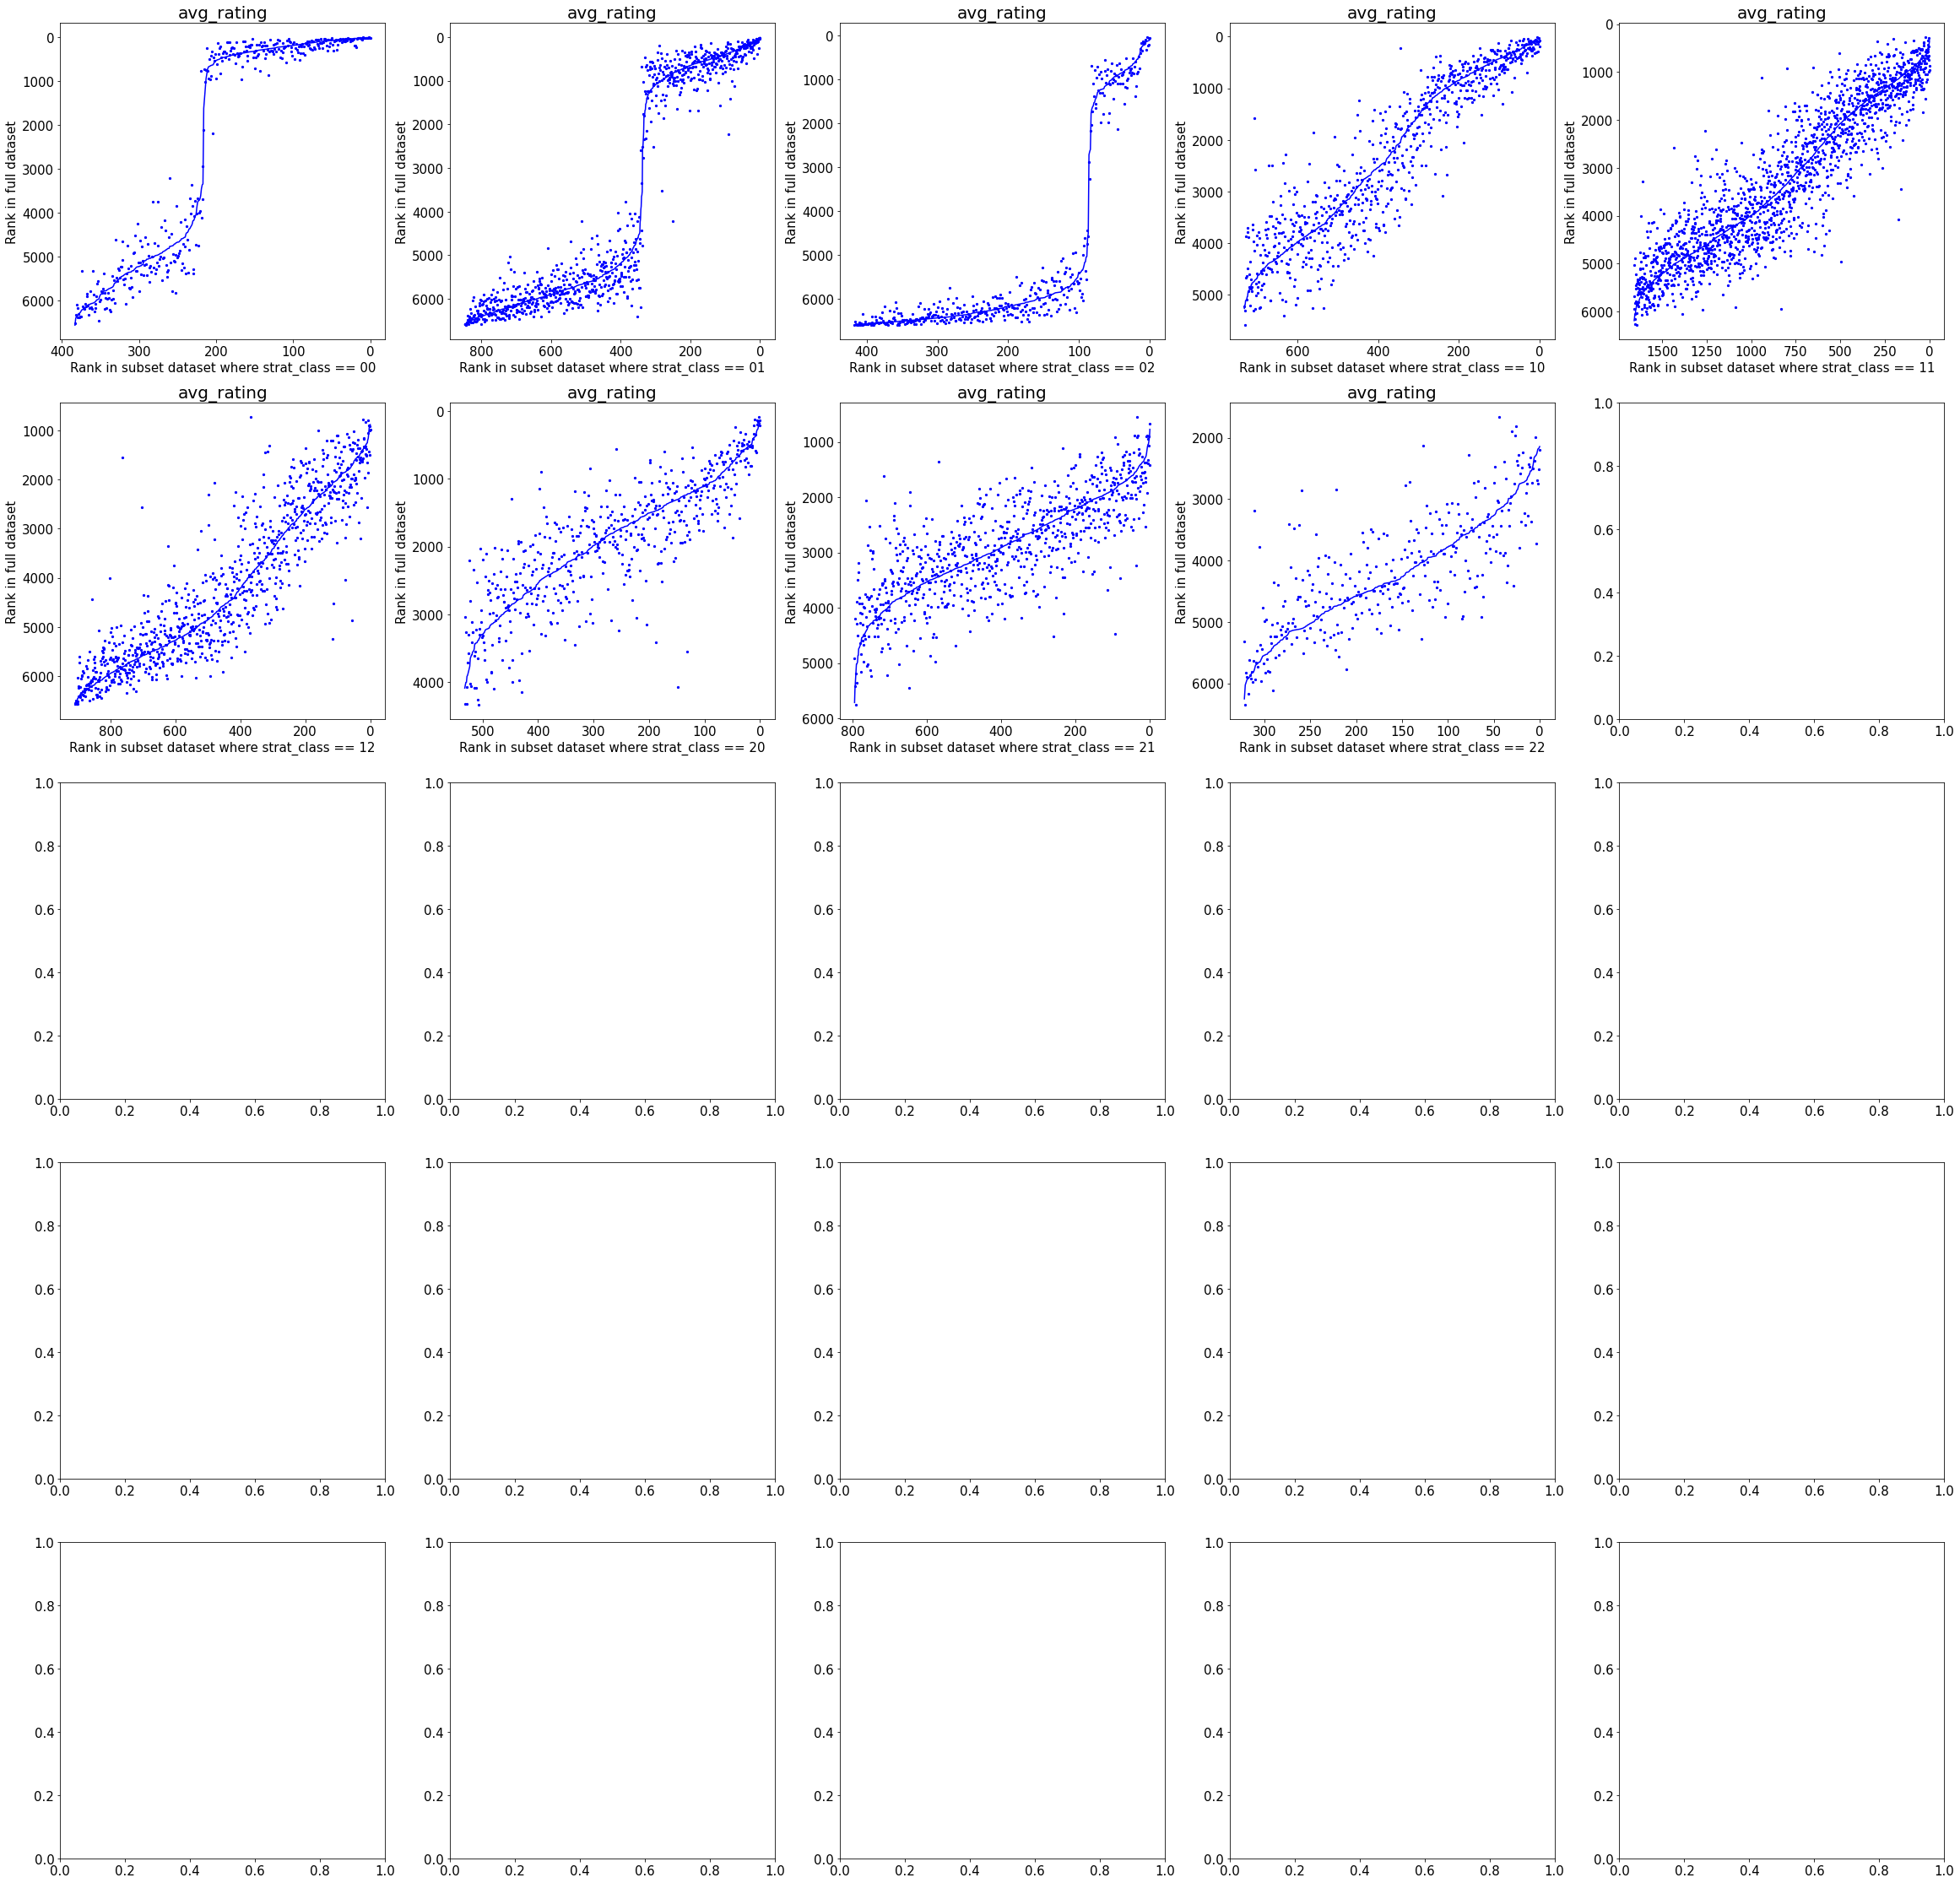

In [36]:
plt.rcParams.update({'font.size': 15})

# start_df
# end_df
df_cut = end_df

data_class = 'strat_class'
# df_0 = df_cut.loc[df_cut[data_class] == 0]
# df_1 = df_cut.loc[df_cut[data_class] == 1]
# df_2 = df_cut.loc[df_cut[data_class] == 2]

var = 'avg_rating'
start_var = var + '_c_start_rank'
end_var = var + '_c_end_rank'
# start_var = var + '_start'
# end_var = var + '_end'

fig, axs = plt.subplots(5,5,figsize=(40,40))
n = 0
m = 0
for i in sorted(df_cut[data_class].value_counts().index):
  df_s = start_df.loc[start_df[data_class] == i]
  df_e = end_df.loc[end_df[data_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0
  
  # Scatter plot
  axs[n][m].scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=5, c='blue')
  axs[n][m].plot(sorted(df_s[start_var].to_list()), c='blue')
  axs[n][m].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, strat_reverse_map[i]))
  axs[n][m].set_ylabel('Rank in full dataset')
  axs[n][m].invert_xaxis()
  axs[n][m].invert_yaxis()
  axs[n][m].set_title("{0}".format(var))
  m += 1

plt.show()

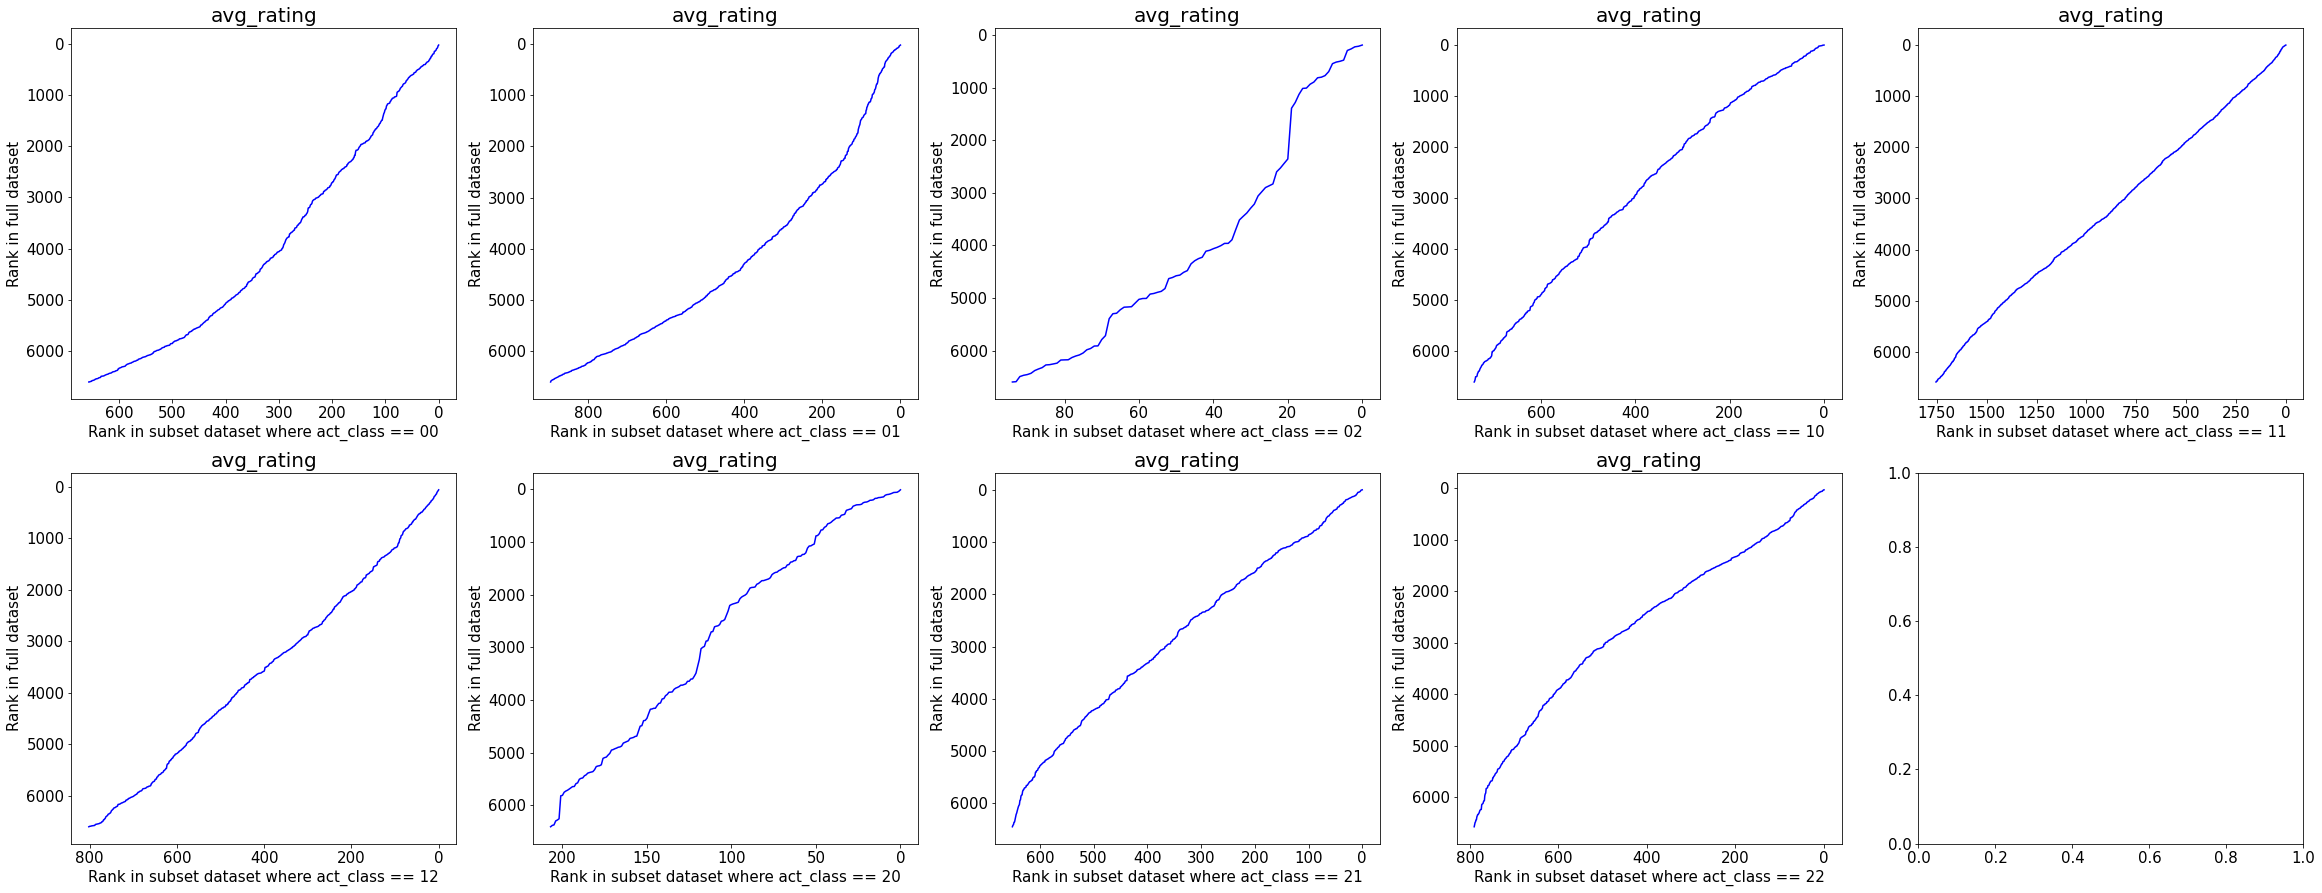

In [37]:
plt.rcParams.update({'font.size': 15})

# start_df
# end_df
df_cut = end_df

data_class = 'act_class'
# df_0 = df_cut.loc[df_cut[data_class] == 0]
# df_1 = df_cut.loc[df_cut[data_class] == 1]
# df_2 = df_cut.loc[df_cut[data_class] == 2]

var = 'avg_rating'
start_var = var + '_c_start_rank'
end_var = var + '_c_end_rank'
# start_var = var + '_start'
# end_var = var + '_end'

fig, axs = plt.subplots(2,5,figsize=(40,15))
n = 0
m = 0
for i in sorted(df_cut[data_class].value_counts().index):
  df_s = start_df.loc[start_df[data_class] == i]
  df_e = end_df.loc[end_df[data_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0
  
  # Scatter plot
  # axs[n][m].scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=5, c='blue')
  
  axs[n][m].plot(sorted(df_s[start_var].to_list()), c='blue')
  axs[n][m].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, strat_reverse_map[i]))
  axs[n][m].set_ylabel('Rank in full dataset')
  axs[n][m].invert_xaxis()
  axs[n][m].invert_yaxis()
  axs[n][m].set_title("{0}".format(var))
  m += 1

plt.show()

### Plot avg_rating change for each of the activity and strategy classes (and combination?)

In [38]:
# plt.rcParams.update({'font.size': 15})

# # start_df
# # end_df
# df_cut = end_df

# data_class = 'strat_class'
# # df_0 = df_cut.loc[df_cut[data_class] == 0]
# # df_1 = df_cut.loc[df_cut[data_class] == 1]
# # df_2 = df_cut.loc[df_cut[data_class] == 2]

# var = 'avg_rating'
# start_var = var + '_c_start'
# end_var = var + '_c_end'
# # start_var = var + '_start'
# # end_var = var + '_end'

# fig, axs = plt.subplots(5,5,figsize=(40,40))
# n = 0
# m = 0
# for i in sorted(df_cut[data_class].value_counts().index):
#   df_s = start_df.loc[start_df[data_class] == i]
#   df_e = end_df.loc[end_df[data_class] == i]

#   indices = np.argsort(df_s[start_var].to_list())
#   if(m == 5):
#     n += 1
#     m = 0
  
#   # Scatter plot
#   axs[n][m].scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=5, c='blue')
#   axs[n][m].plot(sorted(df_s[start_var].to_list()), c='blue')
#   axs[n][m].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, strat_reverse_map[i]))
#   axs[n][m].set_ylabel('Rank in full dataset')
#   # axs[n][m].invert_xaxis()
#   # axs[n][m].invert_yaxis()
#   axs[n][m].set_title("{0}".format(var))
#   m += 1

# plt.show()

In [39]:
# plt.rcParams.update({'font.size': 15})

# # start_df
# # end_df
# df_cut = end_df

# data_class = 'act_class'
# # df_0 = df_cut.loc[df_cut[data_class] == 0]
# # df_1 = df_cut.loc[df_cut[data_class] == 1]
# # df_2 = df_cut.loc[df_cut[data_class] == 2]

# var = 'avg_rating'
# start_var = var + '_c_start'
# end_var = var + '_c_end'
# # start_var = var + '_start'
# # end_var = var + '_end'

# fig, axs = plt.subplots(5,2,figsize=(15,40))
# n = 0
# m = 0
# for i in sorted(df_cut[data_class].value_counts().index):
#   df_s = start_df.loc[start_df[data_class] == i]
#   df_e = end_df.loc[end_df[data_class] == i]

#   indices = np.argsort(df_s[start_var].to_list())
#   if(m == 2):
#     n += 1
#     m = 0
  
#   # Scatter plot
#   axs[n][m].scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=5, c='blue')
#   axs[n][m].plot(sorted(df_s[start_var].to_list()), c='red')
#   axs[n][m].set_xlabel('Rank in subset dataset where {0} == {1}'.format(data_class, act_reverse_map[i]))
#   axs[n][m].set_ylabel('Average rating')
#   # axs[n][m].invert_xaxis()
#   # axs[n][m].invert_yaxis()
#   axs[n][m].set_title("{0}".format(var))
#   m += 1

# plt.show()

### Activity Grouping Stats

In [40]:
row_list = []
for i in range(1,10):
  df_s = start_df.loc[start_df['act_class'] == i]
  df_e = end_df.loc[end_df['act_class'] == i]
  start_ratings = df_s['avg_rating_c_start'].to_list()
  end_ratings = df_e['avg_rating_c_end'].to_list()
  rating_change = [end_ratings[j] - start_ratings[j] for j in range(len(start_ratings))]
  positive_changes = [x for x in rating_change if x > 0]
  negative_changes = [-x for x in rating_change if x <= 0]
  if(len(positive_changes) == 0):
    pos_avg = 0
  else:
    pos_avg = sum(positive_changes)/len(positive_changes)
  
  if(len(negative_changes) == 0):
    neg_avg = 0
  else:
    neg_avg = sum(negative_changes)/len(negative_changes)
  
  pos_percentage = len(positive_changes)/(len(positive_changes) + len(negative_changes)) * 100
  new_row = [act_reverse_map[i], sum(positive_changes), len(positive_changes),pos_avg, sum(negative_changes), len(negative_changes), neg_avg, pos_percentage]
  row_list.append(new_row)


df_activity = pd.DataFrame(row_list, columns=['act_class', 'pos_sum', 'pos_count', 'pos_avg', 'neg_sum', 'neg_count', 'neg_avg', 'pos_pc'])
df_activity.loc[:,['act_class', 'pos_count', 'pos_avg', 'neg_count', 'neg_avg', 'pos_pc']]

,act_class,pos_count,pos_avg,neg_count,neg_avg,pos_pc
0,00,316,55.74038,342,49.36111,48.02432
1,01,492,47.21327,405,40.98949,54.84950
2,02,55,46.84391,40,33.51448,57.89474
3,10,409,49.83513,333,45.85018,55.12129
4,11,945,46.06810,810,40.69836,53.84615
5,12,483,39.38082,320,35.79186,60.14944
6,20,106,48.18689,102,41.77867,50.96154
7,21,365,42.03108,287,35.78291,55.98160
8,22,466,35.33645,325,29.96672,58.91277


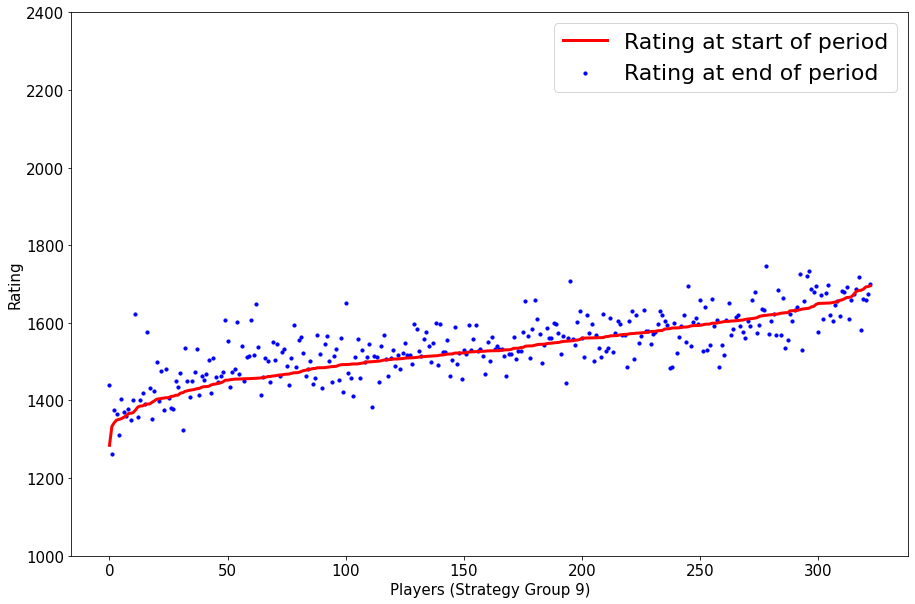

In [53]:
data_class = 'strat_class'

var = 'avg_rating'
start_var = var + '_c_start'
end_var = var + '_c_end'

fig = plt.figure(figsize=(15,10))
ax = plt.axes()
i = 9
df_s = start_df.loc[start_df[data_class] == i]
df_e = end_df.loc[end_df[data_class] == i]

indices = np.argsort(df_s[start_var].to_list())
if(m == 5):
  n += 1
  m = 0

# Scatter plot
plot1 = ax.scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=10, c='blue', label='Rating at end of period')
plot2 = ax.plot(sorted(df_s[start_var].to_list()), c='red', linewidth=3, label='Rating at start of period')
ax.set_xlabel('Players (Strategy Group {0})'.format(i))
ax.set_ylabel('Rating')
ax.legend()
ax.set_ylim(1000,2400)
plt.show()
fig.savefig('strat_class{0}.jpg'.format(i))

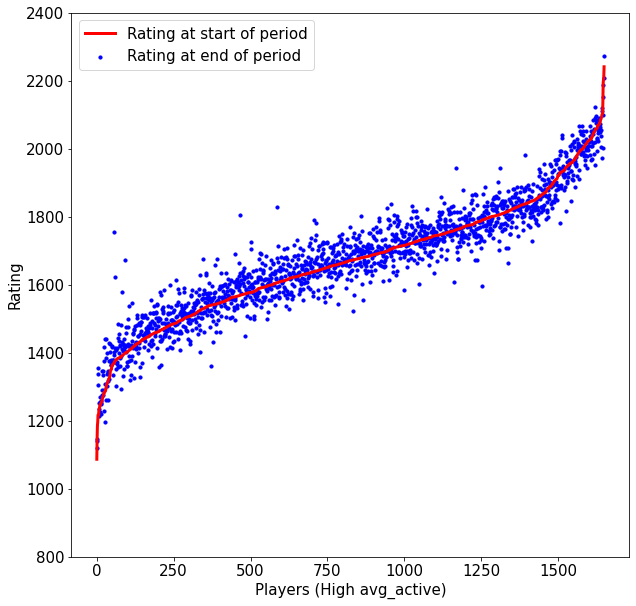

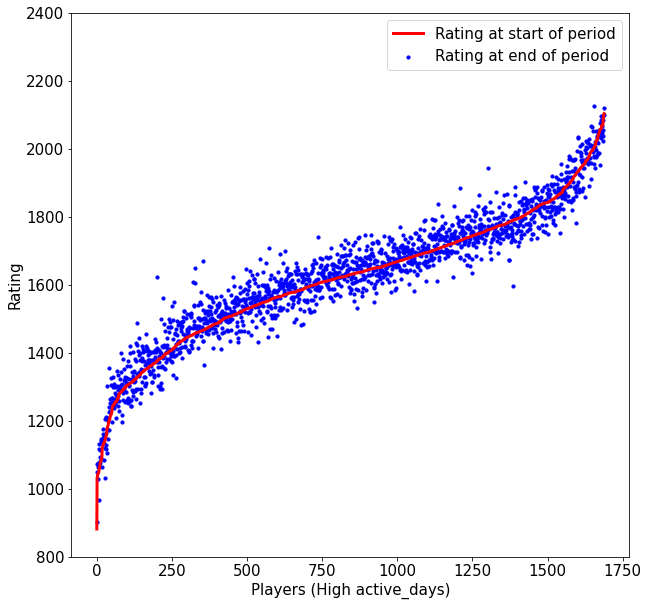

In [43]:
activity_classes = ['avg_active', 'active_days']
for activity_class in activity_classes:
  fig = plt.figure(figsize=(10,10))
  ax = plt.axes()
  i = 2
  df_s = start_df.loc[start_df[activity_class] == i]
  df_e = end_df.loc[end_df[activity_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0
  
  # Scatter plot
  plot1 = ax.scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=10, c='blue', label='Rating at end of period')
  plot2 = ax.plot(sorted(df_s[start_var].to_list()), c='red', linewidth=3, label='Rating at start of period')
  ax.set_xlabel('Players (High {0})'.format(activity_class))
  ax.set_ylabel('Rating')
  ax.legend()
  ax.set_ybound(800,2400)
  plt.show()
  fig.savefig('high_{0}.jpg'.format(activity_class))

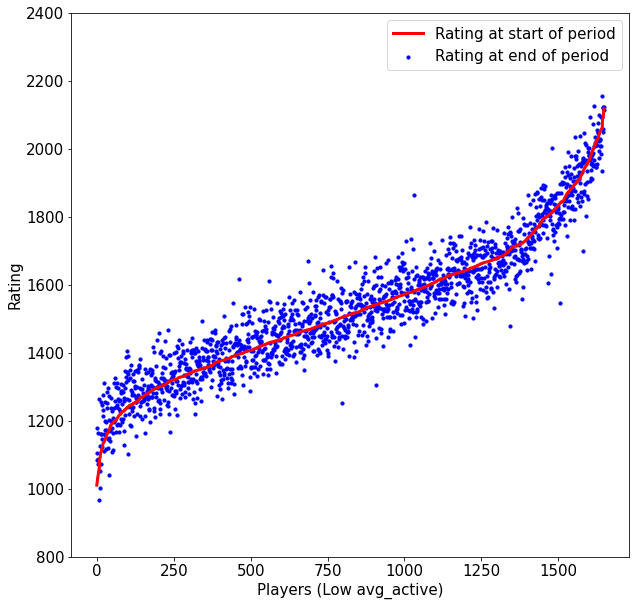

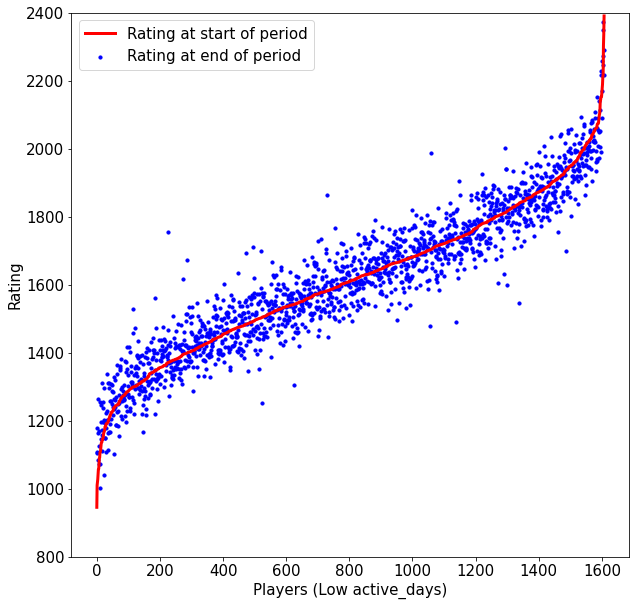

In [44]:
activity_classes = ['avg_active', 'active_days']
for activity_class in activity_classes:
  fig = plt.figure(figsize=(10,10))
  ax = plt.axes()
  i = 0
  df_s = start_df.loc[start_df[activity_class] == i]
  df_e = end_df.loc[end_df[activity_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0

  # Scatter plot
  plot1 = ax.scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=10, c='blue', label='Rating at end of period')
  plot2 = ax.plot(sorted(df_s[start_var].to_list()), c='red', linewidth=3, label='Rating at start of period')
  ax.set_xlabel('Players (Low {0})'.format(activity_class))
  # ax.legend([plot1,plot2],['Rating at start of period', 'Rating at end of period'])
  ax.legend()
  ax.set_ylabel('Rating')
  ax.set_ybound(800,2400)

  plt.show()
  fig.savefig('low_{0}.jpg'.format(activity_class))

In [45]:
row_list = []
for i in range(1,10):
  df_s = start_df.loc[start_df['strat_class'] == i]
  df_e = end_df.loc[end_df['strat_class'] == i]
  start_ratings = df_s['avg_rating_c_start'].to_list()
  end_ratings = df_e['avg_rating_c_end'].to_list()
  rating_change = [end_ratings[j] - start_ratings[j] for j in range(len(start_ratings))]
  positive_changes = [x for x in rating_change if x > 0]
  negative_changes = [-x for x in rating_change if x <= 0]
  
  if(len(positive_changes) == 0):
    pos_avg = 0
  else:
    pos_avg = sum(positive_changes)/len(positive_changes)
  
  if(len(negative_changes) == 0):
    neg_avg = 0
  else:
    neg_avg = sum(negative_changes)/len(negative_changes)
  
  pos_percentage = len(positive_changes)/(len(positive_changes) + len(negative_changes)) * 100
  new_row = [strat_reverse_map[i], sum(positive_changes), len(positive_changes),pos_avg, sum(negative_changes), len(negative_changes), neg_avg, pos_percentage]
  row_list.append(new_row)

df_strategy = pd.DataFrame(row_list, columns=['strat_class', 'pos_sum', 'pos_count', 'pos_avg', 'neg_sum', 'neg_count', 'neg_avg', 'pos_pc'])
df_strategy.loc[:,['strat_class', 'pos_count', 'pos_avg','neg_count', 'neg_avg', 'pos_pc']]

,strat_class,pos_count,pos_avg,neg_count,neg_avg,pos_pc
0,00,182,49.15302,202,40.83913,47.39583
1,01,459,45.67116,389,43.44348,54.12736
2,02,236,48.67101,182,39.43051,56.45933
3,10,367,41.68337,366,44.76497,50.06821
4,11,894,45.26995,763,39.35081,53.95293
5,12,530,51.55659,380,39.40589,58.24176
6,20,298,38.12076,235,36.57678,55.90994
7,21,468,39.91890,327,36.52362,58.86792
8,22,203,43.06247,120,37.77736,62.84830


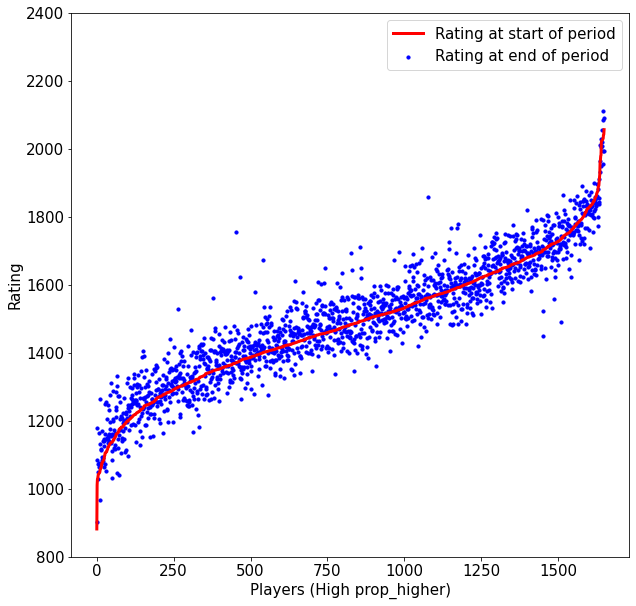

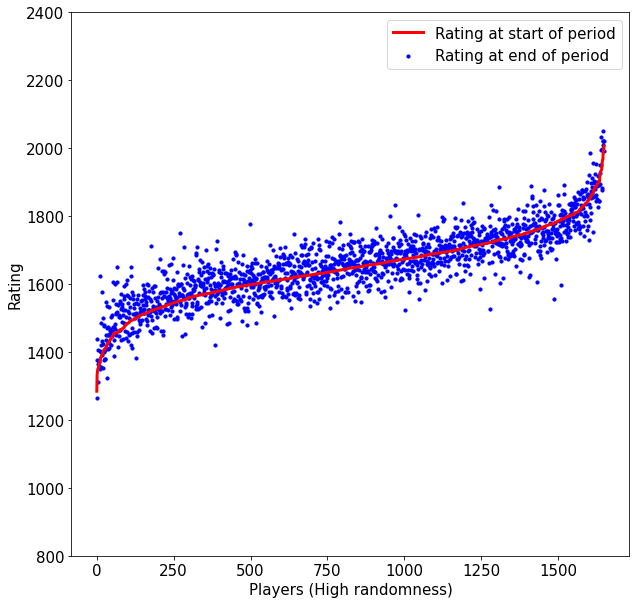

In [46]:
strategy_classes = ['prop_higher', 'randomness']
for strategy_class in strategy_classes:
  fig = plt.figure(figsize=(10,10))
  ax = plt.axes()
  i = 2
  df_s = start_df.loc[start_df[strategy_class] == i]
  df_e = end_df.loc[end_df[strategy_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0
  
  # Scatter plot
  ax.scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=10, c='blue', label='Rating at end of period')
  ax.plot(sorted(df_s[start_var].to_list()), c='red', linewidth=3, label='Rating at start of period')
  ax.set_xlabel('Players (High {0})'.format(strategy_class))
  ax.set_ylabel('Rating')
  ax.legend()
  ax.set_ybound(800,2400)
  plt.show()
  fig.savefig('high_{0}.jpg'.format(strategy_class))

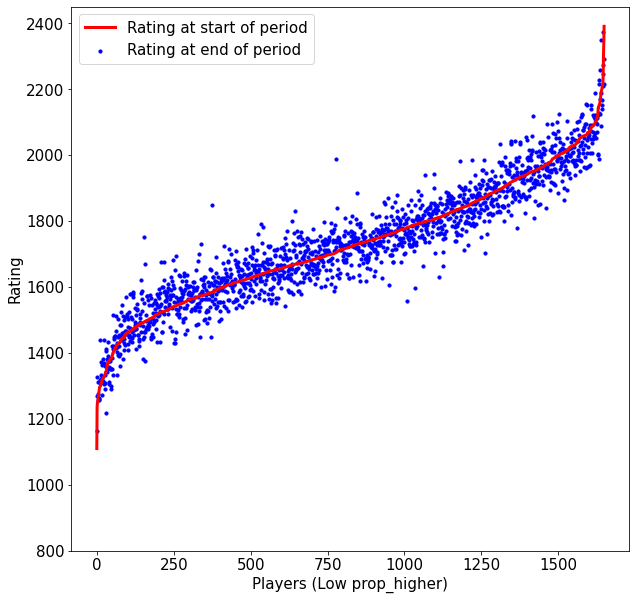

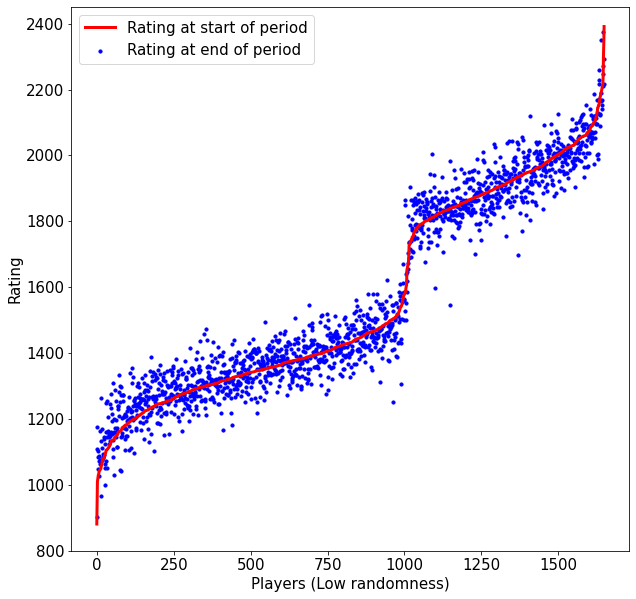

In [47]:
strategy_classes = ['prop_higher', 'randomness']
for strategy_class in strategy_classes:
  fig = plt.figure(figsize=(10,10))
  ax = plt.axes()
  i = 0
  df_s = start_df.loc[start_df[strategy_class] == i]
  df_e = end_df.loc[end_df[strategy_class] == i]

  indices = np.argsort(df_s[start_var].to_list())
  if(m == 5):
    n += 1
    m = 0

  # Scatter plot
  ax.scatter([x for x in range(len(df_e[end_var].to_list()))], (np.array(df_e[end_var].to_list())[indices]), s=10, c='blue', label='Rating at end of period')
  ax.plot(sorted(df_s[start_var].to_list()), c='red', linewidth=3, label='Rating at start of period')
  ax.set_xlabel('Players (Low {0})'.format(strategy_class))
  ax.set_ylabel('Rating')
  ax.set_ybound(800,2450)
  ax.legend()
  plt.show()
  fig.savefig('low_{0}.jpg'.format(strategy_class))

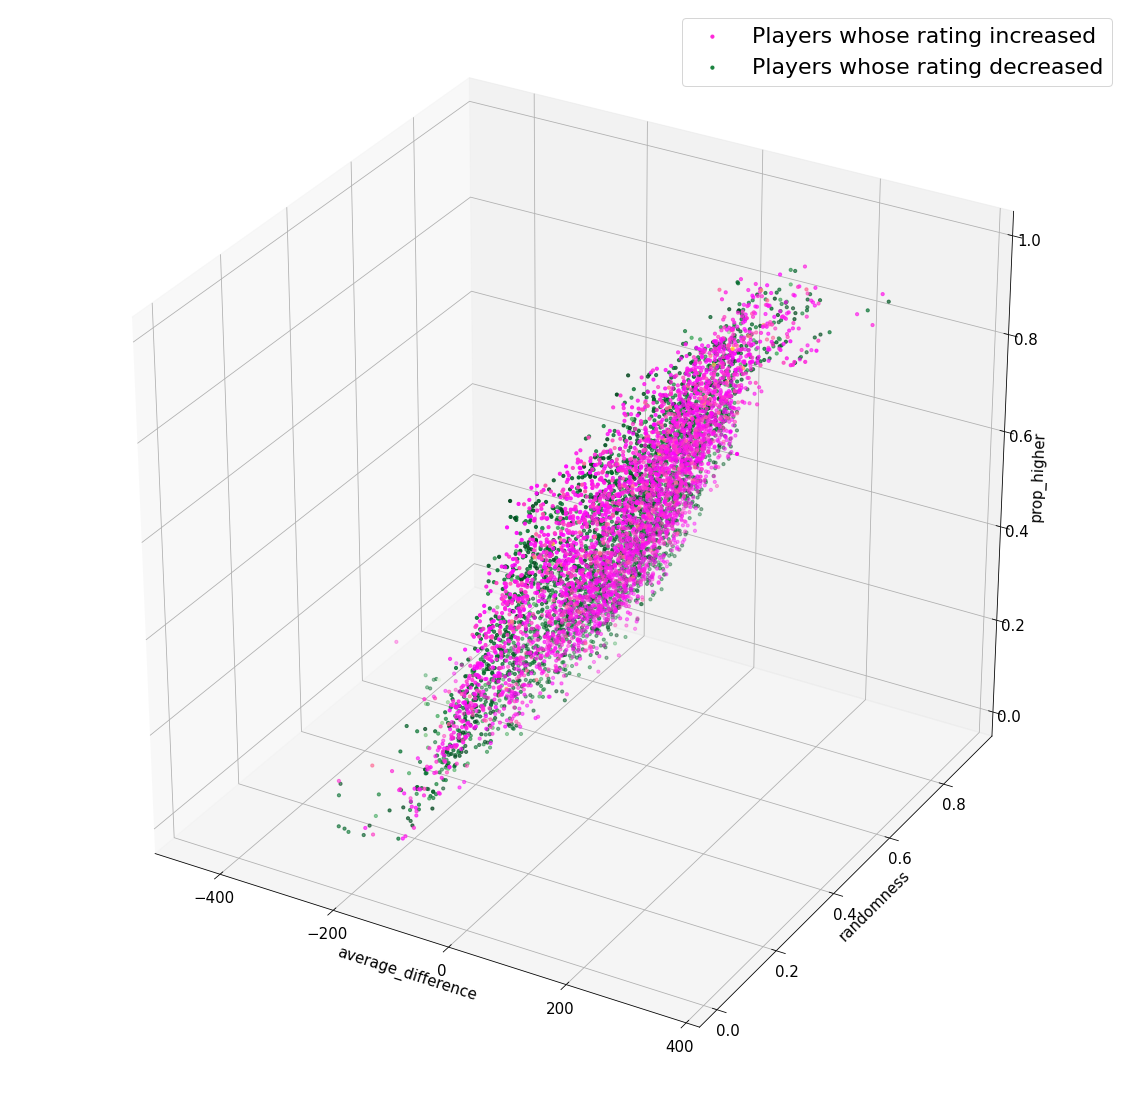

In [48]:
from mpl_toolkits import mplot3d
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
plt.rcParams.update({'font.size': 22})


df_classes = df_progress.loc[:,['active_days', 'avg_active', 'randomness', 'prop_higher', 'average_difference', 'avg_rating_c']]

# x_scaled = min_max_scaler.fit_transform(df_classes.loc[:,['avg_rating_c']])
# df_classes['avg_rating_c'] = x_scaled
# q75, q25 = np.percentile(x_scaled, [75 ,25])

# df_classes = df_classes.loc[(df_classes['avg_rating_c'] > q75) | (df_classes['avg_rating_c'] < q25)]
df_classes_pos = df_classes.loc[(df_classes['avg_rating_c'] > 0)]
df_classes_neg = df_classes.loc[(df_classes['avg_rating_c'] <= 0)]

x = 'average_difference'
y = 'randomness' 
z = 'prop_higher'

# X = np.array(df_classes[x].to_list())
# Y = np.array(df_classes[y].to_list())
# Z = np.array(df_classes[z].to_list())

# fig = plt.figure(figsize=(20,20))
# ax = plt.axes(projection='3d')
# ax.scatter3D(X, Y, Z, c=df_classes['avg_rating_c'].to_list(), cmap='hot')
# ax.set_xlabel(x)
# ax.set_ylabel(y)
# ax.set_zlabel(z)
X_pos = np.array(df_classes_pos[x].to_list())
Y_pos = np.array(df_classes_pos[y].to_list())
Z_pos = np.array(df_classes_pos[z].to_list())

fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pos, Y_pos, Z_pos, c=df_classes_pos['avg_rating_c'].to_list(), cmap='spring', s=10, label='Players whose rating increased')

X_neg = np.array(df_classes_neg[x].to_list())
Y_neg = np.array(df_classes_neg[y].to_list())
Z_neg = np.array(df_classes_neg[z].to_list())

ax.scatter3D(X_neg, Y_neg, Z_neg, c=df_classes_neg['avg_rating_c'].to_list(), cmap='Greens', s=10, label='Players whose rating decreased')
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.legend()
fig.savefig('strategy_grouping.jpg')

In [49]:
coef_c = stats.pearsonr(df_progress['prop_higher'].to_list(), df_progress['average_opponent'].to_list())
coef_c

(-0.10657987500255924, 3.876920986865752e-18)

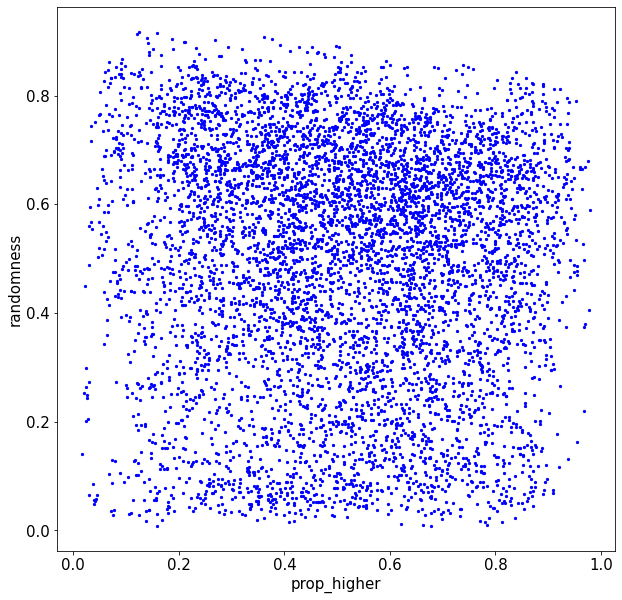

In [50]:
df_classes = df_progress.loc[:,['active_days', 'avg_active', 'randomness', 'prop_higher', 'average_opponent', 'avg_rating_c']]

# x_scaled = min_max_scaler.fit_transform(df_classes.loc[:,['avg_rating_c']])
# df_classes['avg_rating_c'] = x_scaled
# q75, q25 = np.percentile(x_scaled, [75 ,25])

# df_classes = df_classes.loc[(df_classes['avg_rating_c'] > q75) | (df_classes['avg_rating_c'] < q25)]
prog = df_classes['avg_rating_c'].to_list()
X = np.array(df_classes['average_opponent'].to_list())

# min_x = abs(min(X))
# X = [x + min_x for x in X]

df_classes_pos = df_classes.loc[(df_classes['avg_rating_c'] > 0)]
df_classes_neg = df_classes.loc[(df_classes['avg_rating_c'] <= 0)]

x = 'average_opponent'
y = 'randomness'
z = 'prop_higher'

# X_pos = np.array(df_classes_pos[x].to_list())
# Y_pos = np.array(df_classes_pos[y].to_list())
# Z_pos = np.array(df_classes_pos[z].to_list())
# X_neg = np.array(df_classes_neg[x].to_list())
# Y_neg = np.array(df_classes_neg[y].to_list())
# Z_neg = np.array(df_classes_neg[z].to_list())

X = np.array(df_classes[x].to_list())
Y = np.array(df_classes[y].to_list())
Z = np.array(df_classes[z].to_list())

fig = plt.figure(figsize=(10,10))
ax = plt.axes()



ax.scatter(Z, Y, c='blue', s=5)
ax.set_xlabel(z)
ax.set_ylabel(y)
# ax.set_yscale('log')
plt.show()
fig.savefig('prophigh_against_randomness.jpg')

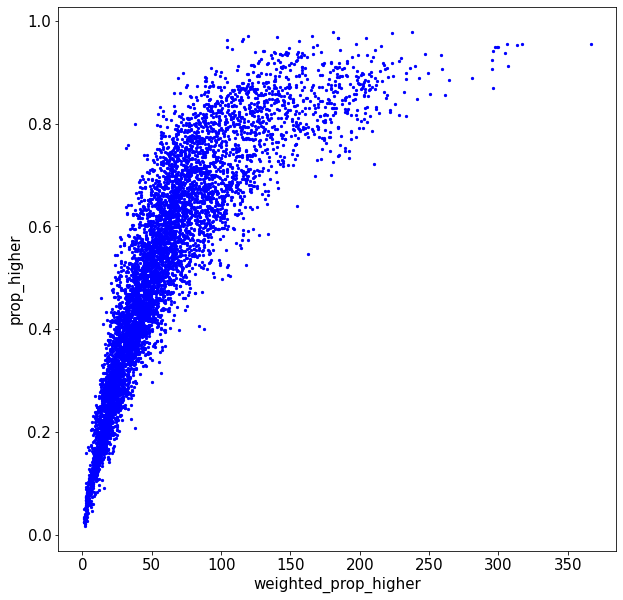

In [51]:
df_classes = df_progress.loc[:,['active_days', 'avg_active', 'randomness', 'average_difference', 'prop_higher', 'weighted_prop_higher', 'avg_rating_c']]

# x_scaled = min_max_scaler.fit_transform(df_classes.loc[:,['avg_rating_c']])
# df_classes['avg_rating_c'] = x_scaled
# q75, q25 = np.percentile(x_scaled, [75 ,25])

# df_classes = df_classes.loc[(df_classes['avg_rating_c'] > q75) | (df_classes['avg_rating_c'] < q25)]
prog = df_classes['avg_rating_c'].to_list()
X = np.array(df_classes['weighted_prop_higher'].to_list())

# min_x = abs(min(X))
# X = [x + min_x for x in X]

df_classes_pos = df_classes.loc[(df_classes['avg_rating_c'] > 0)]
df_classes_neg = df_classes.loc[(df_classes['avg_rating_c'] <= 0)]

x = 'weighted_prop_higher'
y = 'randomness'
z = 'prop_higher'

X_pos = np.array(df_classes_pos[x].to_list())
Y_pos = np.array(df_classes_pos[y].to_list())
Z_pos = np.array(df_classes_pos[z].to_list())

fig = plt.figure(figsize=(10,10))
ax = plt.axes()

X_neg = np.array(df_classes_neg[x].to_list())
Y_neg = np.array(df_classes_neg[y].to_list())
Z_neg = np.array(df_classes_neg[z].to_list())

# ax.scatter(X_pos, Z_pos, c=df_classes_pos['avg_rating_c'].to_list(), cmap='spring', s=5)
# ax.scatter(X_neg, Z_neg, c=df_classes_neg['avg_rating_c'].to_list(), cmap='Greens', s=5)
ax.scatter(X_pos, Z_pos, c='blue', s=5)
ax.scatter(X_neg, Z_neg, c='blue', s=5)
ax.set_xlabel(x)
ax.set_ylabel(z)
# ax.set_yscale('log')
plt.show()
fig.savefig('prop_against_weightedprop.jpg')